In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
%matplotlib qt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


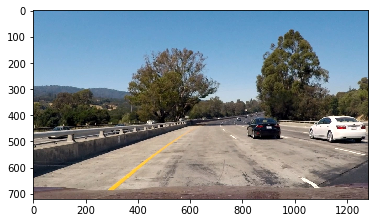

In [2]:
image = mpimg.imread('test_images/test1.jpg')/255
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [4]:
def hls_conversion (image):

    """
    creating the h, l and s channels of hls image from an image
    
    inputs:
        image
    outputs:
        hls
        h_channel
        l_channel
        s_channel
    """
#outimageHSV = np.uint8(outimageHSV)
#outimageBGR = cv2.cvtColor(outimageHSV, cv2.COLOR_HSV2BGR)

    img = np.copy(image)
    img = np.uint8(img)
    #plt.imshow(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    return (hls, h_channel, l_channel, s_channel)

In [5]:
def Camera_calib():
    """"
    
    inputs:
    
    outputs:
        corners
        ret
        mtx
        dist
        rvecs
        tvecs
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    #Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    #images = glob.glob('../camera_cal/calibration*.jpg')
    img_chessboard = []
    image_chess = mpimg.imread('camera_cal/calibration2.jpg')
    #img = []
    #Step through the list and search for chessboard corners
    #for fname in images:
    #img = cv2.imread(fname)
    gray = cv2.cvtColor(image_chess,cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    print(ret)
    #If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        #Draw and display the corners
        img_chessboard = cv2.drawChessboardCorners(image_chess, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    
    return img_chessboard, corners, ret, mtx, dist, rvecs, tvecs
#img_chessboard, corners, ret, mtx, dist, rvecs, tvecs = Camera_calib()
#print(img)
#plt.imshow(img_chessboard)

In [6]:
def undistort (img, mtx, dist):

    """
    
    inputs:
    
    outputs:
        dst
    """
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


In [7]:
def find_sobels(image, l_channel, s_channel, s_thresh=(110, 255), sx_thresh=(0, 255), sy_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):

    """
    applying a color threshold in the HLS color space to detect the lanes

    inputs:
        image
        l_channel
        s_channel
        s_thresh
        sx_thresh
        sy_thresh
        mag_thresh
        dir_thresh
    outputs:
        color_binary_x
        color_binary_y
        mag_binary
        direction_binary
        s_binary_color
    """
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.uint8(image)
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_x = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    mag_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_mag_sobel = np.absolute(mag_sobel)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel_x)
    sxbinary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobel_y)
    sybinary[(scaled_sobel_y >= sy_thresh[0]) & (scaled_sobel_y <= sy_thresh[1])] = 1
    
    # Threshold color channel
    s_binary_color = np.zeros_like(s_channel)
    s_binary_color[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #color_binary_x = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #color_binary_y = np.dstack(( np.zeros_like(sybinary), sybinary, s_binary)) * 255
    
    scaled_magnitude = np.uint8(255*abs_mag_sobel/np.max(abs_mag_sobel))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    
    direction_binary = np.zeros_like(arctan)
    direction_binary[(arctan >= dir_thresh[0]) & (arctan <= dir_thresh[1])] = 1
    
    #return color_binary_x, color_binary_y, mag_binary, direction_binary
    return sxbinary, sybinary, mag_binary, direction_binary, s_binary_color


In [8]:
def combined_sobel(sxbinary, sybinary, mag_binary, direction_binary, s_binary_color):

    """
    combination of diferent gradient measurements
    
    inputs:
        sxbinary
        sybinary
        mag_binary
        direction_binary
        s_binary_color
    outputs:
        combined_all
    """
    
    combined_no_col = np.zeros_like(direction_binary)
    combined_no_col[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (direction_binary == 1))] = 1
    
    combined_all = np.zeros_like(combined_no_col)
    combined_all[(combined_no_col == 1) | (s_binary_color == 1)] = 1
    
    return combined_all

In [9]:
def hist(warped_trans):
    """
    calculating the histogram of image
    
    inputs:
        warped_trans
    outputs:
        histogram
        leftx_current
        rightx_current
    """
    #histogram = np.sum(warped_trans[warped_trans.shape[0]//2:,:], axis=0)
    bottom_half = warped_trans[warped_trans.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    #plt.plot(histogram)
    
    hist_mp = np.int(histogram.shape[0]//2)
    leftx_current = np.argmax(histogram[:hist_mp])
    rightx_current = np.argmax(histogram[hist_mp:]) + hist_mp
    
    return histogram, leftx_current, rightx_current



In [10]:
def find_lane_pixle(binary_warped, leftx_current, rightx_current):

    """
    
    inputs:
        binary_warped
        leftx_current
        rightx_current
    outputs:
        leftx
        lefty
        rightx
        righty
        out_img
    """
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [11]:
def image_tansformation(image, image_size, corners):

    """
    inputs:
        image
        image_size
        corners
    outputs:
        warped
        ransform_matrix
    """
    #defining the corner of source region
    #print(image_size)
    offset = 100
    
    src_corner_ul = [590, 450]
    src_corner_ur = [700, 450]
    src_cornre_ll = [200, 670]
    src_corner_lr = [1100, 700]

    #src_corner_ul = [image_size[0]//2, 450]
    #src_corner_ur = [(image_size[0]//2)+offset, 450]
    #src_cornre_ll = [200, image_size[1]]
    #src_corner_lr = [1000, image_size[1]]
    #print((image_size[0]//2)+offset)
    dst_corner_ul = [200, 0]
    dst_corner_ur = [1000, 0]
    dst_corner_ll = [200, 700]
    dst_corner_lr = [1000, 700]

    src_region = np.float32([src_corner_ul, src_cornre_ll, src_corner_ur, src_corner_lr])
    dst_region = np.float32([dst_corner_ul, dst_corner_ll, dst_corner_ur, dst_corner_lr])
    #print(src_region, 'src')
    #print(dst_region, 'dst')
    
    transform_matrix = []
    transform_matrix = cv2.getPerspectiveTransform(src_region, dst_region)
    warped = []
    warped = cv2.warpPerspective(image, transform_matrix, image_size)
    
    
    return (warped, transform_matrix)

#corners, ret, mtx, dist, rvecs, tvecs, img_chessboard = Camera_calib()
#image_size = (image.shape[1], image.shape[0])    
#warped, transform_matrix = image_tansformation(image, image_size, corners)  
#print(transform_matrix)
#f, (axim1, axim2) = plt.subplots(1,2, figsize=(20,10))
#axim1.imshow(image)
#axim2.imshow(warped)
#plt.imshow(warped)

In [12]:
def fit_polynomial(leftx, lefty, rightx, righty, out_img, binary_warped):

    """
    
    inputs:
        leftx
        lefty
        rightx
        righty
        out_img
        binary_warped
    outputs:
        out_img
        ploty
        left_fitx
        right_fitx
    """
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(left_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='red')
    #plt.plot(right_fitx, ploty, color='red')

    return out_img, ploty, left_fitx, right_fitx



In [13]:
def curvature_not_center_calc(binary_warped, ploty, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):

    """
    
    inputs:
        binary_warped
        ploty
        leftx
        lefty
        rightx
        righty
        xm_per_pix
        ym_per_pix
    outputs:
        left_curverad
        right_curverad
        left_fit
        right_fit
        y_val
    
    """
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])  ## Implement the calculation of the right line here
    
    
    return left_curverad, right_curverad, left_fit, right_fit, y_eval



In [14]:
def calc_veh_center(binary_warped, left_fit, right_fit, y_eval, xm_per_pix):

    """
    
    inputs:
        binary_warped
        left_fit
        right_fit
        y_val
        xm_pix
    outputs:
        center_txt
    """
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = binary_warped.shape[1]//2
    #print(center_image)
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center_txt = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return center_txt

In [15]:
def draw_on_image(undist_img, warped_trans, left_fitx, right_fitx, transform_matrix, left_curverad, right_curverad, center_txt):
    
    """
    
    inputs:
        undist_img
        warped_trans
        left_fitx
        right_fitx
        transform_matrix
        left_curverad
        right_curverad
        center_txt
    outputs:
        final_img
    """
    
    ploty = np.linspace(0, warped_trans.shape[0]-1, warped_trans.shape[0] )

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_trans).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(transform_matrix)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    final_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    cv2.putText(final_img, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_img, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_img, '{}'.format(center_txt), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
        
    return final_img


In [16]:

def myPipeline (binary_warped):
    
    """
    
    inputs:
        binary_warped
    outputs:
        out_img
        warped_trans
        transform_matrix
        ploty, left_curverad
        right_curverad
        left_fitx
        right_fitx
        center_txt
        
    """
    #reading image
    
    #binary_warped = mpimg.imread(image_file)/255
    image_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    #calibration, undistortion
    img_chessboard, corners, ret, mtx, dist, rvecs, tvecs = Camera_calib()
    image_undistored = undistort (binary_warped, mtx, dist) #* 255
    
    #plt.imshow(image_undistored)
    #cv2.imshow("", image_undistored.astype('float32'))
    # color transformation
    hls, h_channel, l_channel, s_channel = hls_conversion(image_undistored)
    sxbinary, sybinary, mag_binary, direction_binary, s_binary_color = find_sobels(image_undistored, l_channel, s_channel, sx_thresh=(20, 80), sy_thresh=(20, 100), mag_thresh=(20, 60), dir_thresh=(0, np.pi/32))
    #binary_image = combined_sobel(color_binary_x, color_binary_y, mag_binary, direction_binary)
    combined_all = combined_sobel(sxbinary, sybinary, mag_binary, direction_binary, s_binary_color)

    #histogram
    #warped_trans, transform_matrix = image_tansformation(binary_warped, image_size, corners)
    warped_trans, transform_matrix = image_tansformation(combined_all, image_size, corners)
    hist_image, leftx_current, rightx_current = hist(warped_trans)
    
    #print(transform_matrix)
    
    #print(leftx_current, ' ', rightx_current)

    leftx, lefty, rightx, righty, out_img = find_lane_pixle(warped_trans, leftx_current, rightx_current)
    out_img, ploty, left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, out_img, warped_trans)
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    image_matrix = []
    left_curverad, right_curverad, left_fit, right_fit, y_eval = curvature_not_center_calc(out_img, ploty, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    center_txt= calc_veh_center(binary_warped, left_fit, right_fit, y_eval, xm_per_pix)
    image_matrix.append(out_img)
    return out_img, image_undistored, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt

image = mpimg.imread('test_images/test1.jpg')
out_img, image_undistored, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt = myPipeline(image)
#plt.plot(right_fitx)
print(transform_matrix)


True
[[ -5.70618627e-01  -1.48340464e+00   9.88807789e+02]
 [  2.06703341e-16  -1.89631666e+00   8.53342498e+02]
 [ -1.10080759e-05  -2.37878152e-03   1.00000000e+00]]


In [17]:
def image_process(image):
    
    """
    
    inputs:
        image_name
    outputs:
        final_img
    """
    
    #plt.imshow(image)
    out_img, image_undistored, warped_trans, transform_matrix, ploty, left_curverad, right_curverad, left_fitx, right_fitx, center_txt = myPipeline(image)
    image_undistored = image_undistored
    final_img = draw_on_image(image_undistored, warped_trans, left_fitx, right_fitx, transform_matrix, left_curverad, right_curverad, center_txt)
    
    #final_img = np.uint8(final_img)
    return final_img #final_image_uint8

True
True
True
True
True
True


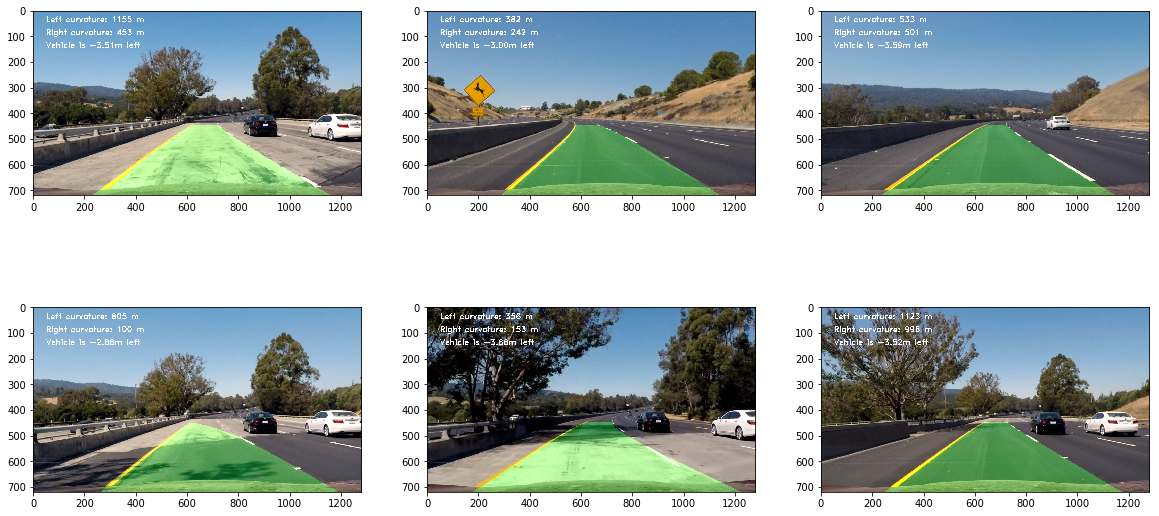

In [18]:
image_adress = 'test_images'
image_array = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

image_matrix = []
f, ((axim1, axim2, axim3), (axim4, axim5, axim6)) = plt.subplots(2,3, figsize=(20,10))
axim = [axim1, axim2, axim3, axim4, axim5, axim6]
img_idx = 0
for image_file in image_array:
    image_name = image_adress+'/'+image_file
    image = mpimg.imread(image_name)
    final_img = image_process(image)
    
    axim[img_idx].imshow(final_img)
    axim[img_idx].set_title = image_name
    img_idx +=1

In [21]:

white_output = "output_video/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4").subclip(0, 50)
#clip1 = VideoFileClip(input_video).subclip(0,5)
white_clip = clip1.fl_image(image_process)
%time white_clip.write_videofile(white_output, audio=False)


True
Moviepy - Building video output_video/project_video.mp4.


t:   0%|          | 2/1250 [00:00<05:02,  4.12it/s, now=None]

Moviepy - Writing video output_video/project_video.mp4

True


t:   0%|          | 3/1250 [00:00<06:35,  3.15it/s, now=None]

True
True


t:   0%|          | 5/1250 [00:02<09:30,  2.18it/s, now=None]

True


t:   0%|          | 6/1250 [00:02<09:31,  2.18it/s, now=None]

True


t:   1%|          | 7/1250 [00:03<10:01,  2.07it/s, now=None]

True
True


t:   1%|          | 9/1250 [00:04<10:02,  2.06it/s, now=None]

True


t:   1%|          | 10/1250 [00:04<09:58,  2.07it/s, now=None]

True


t:   1%|          | 11/1250 [00:05<10:06,  2.04it/s, now=None]

True


t:   1%|          | 12/1250 [00:05<09:56,  2.08it/s, now=None]

True


t:   1%|          | 13/1250 [00:06<09:53,  2.08it/s, now=None]

True


t:   1%|          | 14/1250 [00:06<09:54,  2.08it/s, now=None]

True


t:   1%|          | 15/1250 [00:07<09:59,  2.06it/s, now=None]

True


t:   1%|▏         | 16/1250 [00:07<09:54,  2.07it/s, now=None]

True


t:   1%|▏         | 17/1250 [00:07<09:46,  2.10it/s, now=None]

True


t:   1%|▏         | 18/1250 [00:08<09:40,  2.12it/s, now=None]

True


t:   2%|▏         | 19/1250 [00:08<09:28,  2.17it/s, now=None]

True


t:   2%|▏         | 20/1250 [00:09<09:29,  2.16it/s, now=None]

True


t:   2%|▏         | 21/1250 [00:09<09:32,  2.15it/s, now=None]

True


t:   2%|▏         | 22/1250 [00:10<09:28,  2.16it/s, now=None]

True


t:   2%|▏         | 23/1250 [00:10<09:26,  2.17it/s, now=None]

True


t:   2%|▏         | 24/1250 [00:11<09:30,  2.15it/s, now=None]

True


t:   2%|▏         | 25/1250 [00:11<09:34,  2.13it/s, now=None]

True


t:   2%|▏         | 26/1250 [00:12<09:27,  2.16it/s, now=None]

True


t:   2%|▏         | 27/1250 [00:12<09:29,  2.15it/s, now=None]

True


t:   2%|▏         | 28/1250 [00:13<09:25,  2.16it/s, now=None]

True


t:   2%|▏         | 29/1250 [00:13<09:25,  2.16it/s, now=None]

True


t:   2%|▏         | 30/1250 [00:13<09:21,  2.17it/s, now=None]

True


t:   2%|▏         | 31/1250 [00:14<09:27,  2.15it/s, now=None]

True


t:   3%|▎         | 32/1250 [00:14<09:32,  2.13it/s, now=None]

True


t:   3%|▎         | 33/1250 [00:15<09:24,  2.15it/s, now=None]

True


t:   3%|▎         | 34/1250 [00:15<09:24,  2.15it/s, now=None]

True


t:   3%|▎         | 35/1250 [00:16<09:24,  2.15it/s, now=None]

True


t:   3%|▎         | 36/1250 [00:16<09:19,  2.17it/s, now=None]

True


t:   3%|▎         | 37/1250 [00:17<09:24,  2.15it/s, now=None]

True


t:   3%|▎         | 38/1250 [00:17<09:23,  2.15it/s, now=None]

True


t:   3%|▎         | 39/1250 [00:18<09:14,  2.18it/s, now=None]

True


t:   3%|▎         | 40/1250 [00:18<09:20,  2.16it/s, now=None]

True


t:   3%|▎         | 41/1250 [00:19<09:22,  2.15it/s, now=None]

True


t:   3%|▎         | 42/1250 [00:19<09:19,  2.16it/s, now=None]

True


t:   3%|▎         | 43/1250 [00:20<09:12,  2.19it/s, now=None]

True


t:   4%|▎         | 44/1250 [00:20<08:35,  2.34it/s, now=None]

True


t:   4%|▎         | 45/1250 [00:20<08:47,  2.29it/s, now=None]

True


t:   4%|▎         | 46/1250 [00:21<09:02,  2.22it/s, now=None]

True


t:   4%|▍         | 47/1250 [00:21<09:07,  2.20it/s, now=None]

True


t:   4%|▍         | 48/1250 [00:22<09:16,  2.16it/s, now=None]

True


t:   4%|▍         | 49/1250 [00:22<09:24,  2.13it/s, now=None]

True


t:   4%|▍         | 50/1250 [00:23<09:11,  2.17it/s, now=None]

True


t:   4%|▍         | 51/1250 [00:23<09:13,  2.17it/s, now=None]

True


t:   4%|▍         | 52/1250 [00:24<09:21,  2.13it/s, now=None]

True


t:   4%|▍         | 53/1250 [00:24<09:10,  2.17it/s, now=None]

True


t:   4%|▍         | 54/1250 [00:25<09:10,  2.17it/s, now=None]

True


t:   4%|▍         | 55/1250 [00:25<09:14,  2.16it/s, now=None]

True


t:   4%|▍         | 56/1250 [00:25<09:19,  2.13it/s, now=None]

True


t:   5%|▍         | 57/1250 [00:26<09:26,  2.10it/s, now=None]

True


t:   5%|▍         | 58/1250 [00:26<09:24,  2.11it/s, now=None]

True


t:   5%|▍         | 59/1250 [00:27<09:20,  2.13it/s, now=None]

True


t:   5%|▍         | 60/1250 [00:27<09:20,  2.12it/s, now=None]

True


t:   5%|▍         | 61/1250 [00:28<09:09,  2.16it/s, now=None]

True


t:   5%|▍         | 62/1250 [00:28<09:13,  2.15it/s, now=None]

True


t:   5%|▌         | 63/1250 [00:29<09:19,  2.12it/s, now=None]

True


t:   5%|▌         | 64/1250 [00:29<09:10,  2.15it/s, now=None]

True


t:   5%|▌         | 65/1250 [00:30<09:05,  2.17it/s, now=None]

True


t:   5%|▌         | 66/1250 [00:30<08:58,  2.20it/s, now=None]

True


t:   5%|▌         | 67/1250 [00:31<09:04,  2.17it/s, now=None]

True


t:   5%|▌         | 68/1250 [00:31<09:02,  2.18it/s, now=None]

True


t:   6%|▌         | 69/1250 [00:31<08:53,  2.21it/s, now=None]

True


t:   6%|▌         | 70/1250 [00:32<09:03,  2.17it/s, now=None]

True


t:   6%|▌         | 71/1250 [00:32<08:56,  2.20it/s, now=None]

True


t:   6%|▌         | 72/1250 [00:33<09:09,  2.14it/s, now=None]

True


t:   6%|▌         | 73/1250 [00:33<08:59,  2.18it/s, now=None]

True


t:   6%|▌         | 74/1250 [00:34<08:58,  2.18it/s, now=None]

True


t:   6%|▌         | 75/1250 [00:34<09:07,  2.14it/s, now=None]

True


t:   6%|▌         | 76/1250 [00:35<09:09,  2.14it/s, now=None]

True


t:   6%|▌         | 77/1250 [00:35<09:13,  2.12it/s, now=None]

True


t:   6%|▌         | 78/1250 [00:36<09:03,  2.16it/s, now=None]

True


t:   6%|▋         | 79/1250 [00:36<09:10,  2.13it/s, now=None]

True


t:   6%|▋         | 80/1250 [00:37<09:14,  2.11it/s, now=None]

True


t:   6%|▋         | 81/1250 [00:37<09:02,  2.16it/s, now=None]

True


t:   7%|▋         | 82/1250 [00:38<08:58,  2.17it/s, now=None]

True


t:   7%|▋         | 83/1250 [00:38<09:09,  2.12it/s, now=None]

True


t:   7%|▋         | 84/1250 [00:38<09:02,  2.15it/s, now=None]

True


t:   7%|▋         | 85/1250 [00:39<08:58,  2.16it/s, now=None]

True


t:   7%|▋         | 86/1250 [00:39<08:50,  2.19it/s, now=None]

True


t:   7%|▋         | 87/1250 [00:40<08:55,  2.17it/s, now=None]

True


t:   7%|▋         | 88/1250 [00:40<08:55,  2.17it/s, now=None]

True


t:   7%|▋         | 89/1250 [00:41<09:01,  2.14it/s, now=None]

True


t:   7%|▋         | 90/1250 [00:41<08:51,  2.18it/s, now=None]

True


t:   7%|▋         | 91/1250 [00:42<08:58,  2.15it/s, now=None]

True


t:   7%|▋         | 92/1250 [00:42<09:03,  2.13it/s, now=None]

True


t:   7%|▋         | 93/1250 [00:43<08:56,  2.16it/s, now=None]

True


t:   8%|▊         | 94/1250 [00:43<08:48,  2.19it/s, now=None]

True


t:   8%|▊         | 95/1250 [00:44<08:49,  2.18it/s, now=None]

True


t:   8%|▊         | 96/1250 [00:44<08:49,  2.18it/s, now=None]

True


t:   8%|▊         | 97/1250 [00:44<08:42,  2.21it/s, now=None]

True


t:   8%|▊         | 98/1250 [00:45<08:40,  2.21it/s, now=None]

True


t:   8%|▊         | 99/1250 [00:45<08:47,  2.18it/s, now=None]

True


t:   8%|▊         | 100/1250 [00:46<08:48,  2.18it/s, now=None]

True


t:   8%|▊         | 101/1250 [00:46<08:47,  2.18it/s, now=None]

True


t:   8%|▊         | 102/1250 [00:47<08:51,  2.16it/s, now=None]

True


t:   8%|▊         | 103/1250 [00:47<08:55,  2.14it/s, now=None]

True


t:   8%|▊         | 104/1250 [00:48<08:53,  2.15it/s, now=None]

True


t:   8%|▊         | 105/1250 [00:48<08:51,  2.16it/s, now=None]

True


t:   8%|▊         | 106/1250 [00:49<08:46,  2.17it/s, now=None]

True


t:   9%|▊         | 107/1250 [00:49<08:44,  2.18it/s, now=None]

True


t:   9%|▊         | 108/1250 [00:50<08:46,  2.17it/s, now=None]

True


t:   9%|▊         | 109/1250 [00:50<08:39,  2.20it/s, now=None]

True


t:   9%|▉         | 110/1250 [00:50<08:44,  2.17it/s, now=None]

True


t:   9%|▉         | 111/1250 [00:51<09:05,  2.09it/s, now=None]

True


t:   9%|▉         | 112/1250 [00:51<08:59,  2.11it/s, now=None]

True


t:   9%|▉         | 113/1250 [00:52<08:54,  2.13it/s, now=None]

True


t:   9%|▉         | 114/1250 [00:52<08:59,  2.10it/s, now=None]

True


t:   9%|▉         | 115/1250 [00:53<08:50,  2.14it/s, now=None]

True


t:   9%|▉         | 116/1250 [00:53<08:54,  2.12it/s, now=None]

True


t:   9%|▉         | 117/1250 [00:54<08:51,  2.13it/s, now=None]

True


t:   9%|▉         | 118/1250 [00:54<08:47,  2.15it/s, now=None]

True


t:  10%|▉         | 119/1250 [00:55<08:44,  2.15it/s, now=None]

True


t:  10%|▉         | 120/1250 [00:55<08:45,  2.15it/s, now=None]

True


t:  10%|▉         | 121/1250 [00:56<08:47,  2.14it/s, now=None]

True


t:  10%|▉         | 122/1250 [00:56<08:50,  2.13it/s, now=None]

True


t:  10%|▉         | 123/1250 [00:57<08:47,  2.14it/s, now=None]

True


t:  10%|▉         | 124/1250 [00:57<08:51,  2.12it/s, now=None]

True


t:  10%|█         | 125/1250 [00:57<08:37,  2.17it/s, now=None]

True


t:  10%|█         | 126/1250 [00:58<08:33,  2.19it/s, now=None]

True


t:  10%|█         | 127/1250 [00:58<08:27,  2.21it/s, now=None]

True


t:  10%|█         | 128/1250 [00:59<08:33,  2.19it/s, now=None]

True


t:  10%|█         | 129/1250 [00:59<08:27,  2.21it/s, now=None]

True


t:  10%|█         | 130/1250 [01:00<08:17,  2.25it/s, now=None]

True


t:  10%|█         | 131/1250 [01:00<08:17,  2.25it/s, now=None]

True


t:  11%|█         | 132/1250 [01:01<08:37,  2.16it/s, now=None]

True
True


t:  11%|█         | 133/1250 [01:01<09:33,  1.95it/s, now=None]

True


t:  11%|█         | 134/1250 [01:02<09:42,  1.92it/s, now=None]

True


t:  11%|█         | 135/1250 [01:02<10:26,  1.78it/s, now=None]

True


t:  11%|█         | 137/1250 [01:03<09:43,  1.91it/s, now=None]

True


t:  11%|█         | 138/1250 [01:04<09:19,  1.99it/s, now=None]

True


t:  11%|█         | 139/1250 [01:04<09:10,  2.02it/s, now=None]

True


t:  11%|█         | 140/1250 [01:05<09:05,  2.04it/s, now=None]

True


t:  11%|█▏        | 141/1250 [01:05<08:51,  2.09it/s, now=None]

True
True


t:  11%|█▏        | 143/1250 [01:06<08:55,  2.07it/s, now=None]

True
True


t:  12%|█▏        | 144/1250 [01:07<09:09,  2.01it/s, now=None]

True


t:  12%|█▏        | 146/1250 [01:08<09:33,  1.93it/s, now=None]

True


t:  12%|█▏        | 147/1250 [01:08<09:20,  1.97it/s, now=None]

True


t:  12%|█▏        | 148/1250 [01:09<09:15,  1.98it/s, now=None]

True


t:  12%|█▏        | 149/1250 [01:09<09:05,  2.02it/s, now=None]

True


t:  12%|█▏        | 150/1250 [01:10<09:15,  1.98it/s, now=None]

True


t:  12%|█▏        | 151/1250 [01:10<09:06,  2.01it/s, now=None]

True


t:  12%|█▏        | 152/1250 [01:11<08:52,  2.06it/s, now=None]

True


t:  12%|█▏        | 153/1250 [01:11<09:03,  2.02it/s, now=None]

True


t:  12%|█▏        | 154/1250 [01:12<08:58,  2.03it/s, now=None]

True


t:  12%|█▏        | 155/1250 [01:12<08:53,  2.05it/s, now=None]

True


t:  12%|█▏        | 156/1250 [01:13<08:37,  2.11it/s, now=None]

True


t:  13%|█▎        | 157/1250 [01:13<08:40,  2.10it/s, now=None]

True


t:  13%|█▎        | 158/1250 [01:14<08:36,  2.11it/s, now=None]

True


t:  13%|█▎        | 159/1250 [01:14<08:41,  2.09it/s, now=None]

True


t:  13%|█▎        | 160/1250 [01:15<08:45,  2.07it/s, now=None]

True


t:  13%|█▎        | 161/1250 [01:15<08:47,  2.06it/s, now=None]

True


t:  13%|█▎        | 162/1250 [01:16<08:40,  2.09it/s, now=None]

True


t:  13%|█▎        | 163/1250 [01:16<08:53,  2.04it/s, now=None]

True


t:  13%|█▎        | 164/1250 [01:17<08:51,  2.04it/s, now=None]

True


t:  13%|█▎        | 165/1250 [01:17<08:42,  2.07it/s, now=None]

True


t:  13%|█▎        | 166/1250 [01:18<08:26,  2.14it/s, now=None]

True


t:  13%|█▎        | 167/1250 [01:18<08:25,  2.14it/s, now=None]

True


t:  13%|█▎        | 168/1250 [01:19<08:20,  2.16it/s, now=None]

True


t:  14%|█▎        | 169/1250 [01:19<08:25,  2.14it/s, now=None]

True


t:  14%|█▎        | 170/1250 [01:19<08:19,  2.16it/s, now=None]

True


t:  14%|█▎        | 171/1250 [01:20<08:25,  2.13it/s, now=None]

True


t:  14%|█▍        | 172/1250 [01:20<08:24,  2.14it/s, now=None]

True


t:  14%|█▍        | 173/1250 [01:21<08:18,  2.16it/s, now=None]

True


t:  14%|█▍        | 174/1250 [01:21<08:15,  2.17it/s, now=None]

True


t:  14%|█▍        | 175/1250 [01:22<08:24,  2.13it/s, now=None]

True


t:  14%|█▍        | 176/1250 [01:22<08:29,  2.11it/s, now=None]

True


t:  14%|█▍        | 177/1250 [01:23<08:21,  2.14it/s, now=None]

True


t:  14%|█▍        | 178/1250 [01:23<08:28,  2.11it/s, now=None]

True


t:  14%|█▍        | 179/1250 [01:24<08:29,  2.10it/s, now=None]

True


t:  14%|█▍        | 180/1250 [01:24<08:20,  2.14it/s, now=None]

True


t:  14%|█▍        | 181/1250 [01:25<08:14,  2.16it/s, now=None]

True


t:  15%|█▍        | 182/1250 [01:25<08:15,  2.16it/s, now=None]

True


t:  15%|█▍        | 183/1250 [01:26<08:19,  2.14it/s, now=None]

True


t:  15%|█▍        | 184/1250 [01:26<08:06,  2.19it/s, now=None]

True


t:  15%|█▍        | 185/1250 [01:26<08:02,  2.21it/s, now=None]

True


t:  15%|█▍        | 186/1250 [01:27<08:07,  2.18it/s, now=None]

True


t:  15%|█▍        | 187/1250 [01:27<08:06,  2.18it/s, now=None]

True


t:  15%|█▌        | 188/1250 [01:28<08:12,  2.16it/s, now=None]

True


t:  15%|█▌        | 189/1250 [01:28<08:15,  2.14it/s, now=None]

True


t:  15%|█▌        | 190/1250 [01:29<08:12,  2.15it/s, now=None]

True


t:  15%|█▌        | 191/1250 [01:29<08:15,  2.14it/s, now=None]

True


t:  15%|█▌        | 192/1250 [01:30<08:20,  2.11it/s, now=None]

True


t:  15%|█▌        | 193/1250 [01:30<08:13,  2.14it/s, now=None]

True


t:  16%|█▌        | 194/1250 [01:31<08:14,  2.14it/s, now=None]

True


t:  16%|█▌        | 195/1250 [01:31<08:13,  2.14it/s, now=None]

True


t:  16%|█▌        | 196/1250 [01:32<08:15,  2.13it/s, now=None]

True


t:  16%|█▌        | 197/1250 [01:32<08:04,  2.17it/s, now=None]

True


t:  16%|█▌        | 198/1250 [01:32<08:06,  2.16it/s, now=None]

True


t:  16%|█▌        | 199/1250 [01:33<08:17,  2.11it/s, now=None]

True


t:  16%|█▌        | 200/1250 [01:33<08:13,  2.13it/s, now=None]

True


t:  16%|█▌        | 201/1250 [01:34<08:11,  2.14it/s, now=None]

True


t:  16%|█▌        | 202/1250 [01:34<07:59,  2.18it/s, now=None]

True


t:  16%|█▌        | 203/1250 [01:35<08:06,  2.15it/s, now=None]

True


t:  16%|█▋        | 204/1250 [01:35<08:08,  2.14it/s, now=None]

True


t:  16%|█▋        | 205/1250 [01:36<08:01,  2.17it/s, now=None]

True


t:  16%|█▋        | 206/1250 [01:36<08:00,  2.17it/s, now=None]

True


t:  17%|█▋        | 207/1250 [01:37<08:07,  2.14it/s, now=None]

True


t:  17%|█▋        | 208/1250 [01:37<08:16,  2.10it/s, now=None]

True


t:  17%|█▋        | 209/1250 [01:38<08:08,  2.13it/s, now=None]

True


t:  17%|█▋        | 210/1250 [01:38<08:11,  2.12it/s, now=None]

True


t:  17%|█▋        | 211/1250 [01:39<08:09,  2.12it/s, now=None]

True


t:  17%|█▋        | 212/1250 [01:39<08:11,  2.11it/s, now=None]

True


t:  17%|█▋        | 213/1250 [01:40<08:02,  2.15it/s, now=None]

True


t:  17%|█▋        | 214/1250 [01:40<08:10,  2.11it/s, now=None]

True


t:  17%|█▋        | 215/1250 [01:40<08:10,  2.11it/s, now=None]

True


t:  17%|█▋        | 216/1250 [01:41<08:19,  2.07it/s, now=None]

True


t:  17%|█▋        | 217/1250 [01:41<08:07,  2.12it/s, now=None]

True


t:  17%|█▋        | 218/1250 [01:42<08:05,  2.13it/s, now=None]

True


t:  18%|█▊        | 219/1250 [01:42<08:06,  2.12it/s, now=None]

True


t:  18%|█▊        | 220/1250 [01:43<08:07,  2.11it/s, now=None]

True


t:  18%|█▊        | 221/1250 [01:43<07:58,  2.15it/s, now=None]

True


t:  18%|█▊        | 222/1250 [01:44<07:58,  2.15it/s, now=None]

True


t:  18%|█▊        | 223/1250 [01:44<08:03,  2.12it/s, now=None]

True


t:  18%|█▊        | 224/1250 [01:45<08:03,  2.12it/s, now=None]

True


t:  18%|█▊        | 225/1250 [01:45<08:06,  2.11it/s, now=None]

True


t:  18%|█▊        | 226/1250 [01:46<08:05,  2.11it/s, now=None]

True


t:  18%|█▊        | 227/1250 [01:46<08:08,  2.10it/s, now=None]

True


t:  18%|█▊        | 228/1250 [01:47<08:12,  2.07it/s, now=None]

True


t:  18%|█▊        | 229/1250 [01:47<08:04,  2.11it/s, now=None]

True


t:  18%|█▊        | 230/1250 [01:48<08:06,  2.10it/s, now=None]

True


t:  18%|█▊        | 231/1250 [01:48<08:01,  2.12it/s, now=None]

True


t:  19%|█▊        | 232/1250 [01:49<07:58,  2.13it/s, now=None]

True


t:  19%|█▊        | 233/1250 [01:49<07:55,  2.14it/s, now=None]

True


t:  19%|█▊        | 234/1250 [01:49<07:48,  2.17it/s, now=None]

True


t:  19%|█▉        | 235/1250 [01:50<07:55,  2.13it/s, now=None]

True


t:  19%|█▉        | 236/1250 [01:50<07:56,  2.13it/s, now=None]

True


t:  19%|█▉        | 237/1250 [01:51<07:58,  2.12it/s, now=None]

True


t:  19%|█▉        | 238/1250 [01:51<07:49,  2.15it/s, now=None]

True


t:  19%|█▉        | 239/1250 [01:52<07:58,  2.11it/s, now=None]

True


t:  19%|█▉        | 240/1250 [01:52<07:59,  2.10it/s, now=None]

True


t:  19%|█▉        | 241/1250 [01:53<08:00,  2.10it/s, now=None]

True


t:  19%|█▉        | 242/1250 [01:53<07:53,  2.13it/s, now=None]

True


t:  19%|█▉        | 243/1250 [01:54<07:55,  2.12it/s, now=None]

True


t:  20%|█▉        | 244/1250 [01:54<07:47,  2.15it/s, now=None]

True


t:  20%|█▉        | 245/1250 [01:55<07:40,  2.18it/s, now=None]

True


t:  20%|█▉        | 246/1250 [01:55<07:45,  2.16it/s, now=None]

True


t:  20%|█▉        | 247/1250 [01:56<07:48,  2.14it/s, now=None]

True


t:  20%|█▉        | 248/1250 [01:56<07:49,  2.13it/s, now=None]

True


t:  20%|█▉        | 249/1250 [01:56<07:42,  2.16it/s, now=None]

True


t:  20%|██        | 250/1250 [01:57<07:41,  2.17it/s, now=None]

True


t:  20%|██        | 251/1250 [01:57<07:34,  2.20it/s, now=None]

True


t:  20%|██        | 252/1250 [01:58<07:36,  2.19it/s, now=None]

True


t:  20%|██        | 253/1250 [01:58<07:31,  2.21it/s, now=None]

True


t:  20%|██        | 254/1250 [01:59<07:36,  2.18it/s, now=None]

True


t:  20%|██        | 255/1250 [01:59<07:39,  2.17it/s, now=None]

True


t:  20%|██        | 256/1250 [02:00<07:41,  2.15it/s, now=None]

True


t:  21%|██        | 257/1250 [02:00<07:34,  2.19it/s, now=None]

True


t:  21%|██        | 258/1250 [02:01<07:40,  2.16it/s, now=None]

True


t:  21%|██        | 259/1250 [02:01<07:44,  2.14it/s, now=None]

True


t:  21%|██        | 260/1250 [02:02<07:51,  2.10it/s, now=None]

True


t:  21%|██        | 261/1250 [02:02<07:42,  2.14it/s, now=None]

True


t:  21%|██        | 262/1250 [02:02<07:42,  2.14it/s, now=None]

True


t:  21%|██        | 263/1250 [02:03<07:49,  2.10it/s, now=None]

True


t:  21%|██        | 264/1250 [02:03<07:44,  2.12it/s, now=None]

True


t:  21%|██        | 265/1250 [02:04<07:40,  2.14it/s, now=None]

True


t:  21%|██▏       | 266/1250 [02:04<07:34,  2.17it/s, now=None]

True


t:  21%|██▏       | 267/1250 [02:05<07:45,  2.11it/s, now=None]

True


t:  21%|██▏       | 268/1250 [02:05<07:40,  2.13it/s, now=None]

True


t:  22%|██▏       | 269/1250 [02:06<07:36,  2.15it/s, now=None]

True


t:  22%|██▏       | 270/1250 [02:06<07:40,  2.13it/s, now=None]

True


t:  22%|██▏       | 271/1250 [02:07<07:40,  2.13it/s, now=None]

True


t:  22%|██▏       | 272/1250 [02:07<07:41,  2.12it/s, now=None]

True


t:  22%|██▏       | 273/1250 [02:08<07:48,  2.08it/s, now=None]

True


t:  22%|██▏       | 274/1250 [02:08<07:54,  2.06it/s, now=None]

True


t:  22%|██▏       | 275/1250 [02:09<07:55,  2.05it/s, now=None]

True


t:  22%|██▏       | 276/1250 [02:09<08:02,  2.02it/s, now=None]

True


t:  22%|██▏       | 277/1250 [02:10<07:51,  2.06it/s, now=None]

True


t:  22%|██▏       | 278/1250 [02:10<07:52,  2.06it/s, now=None]

True


t:  22%|██▏       | 279/1250 [02:11<07:52,  2.05it/s, now=None]

True


t:  22%|██▏       | 280/1250 [02:11<07:44,  2.09it/s, now=None]

True


t:  22%|██▏       | 281/1250 [02:12<07:37,  2.12it/s, now=None]

True


t:  23%|██▎       | 282/1250 [02:12<07:38,  2.11it/s, now=None]

True


t:  23%|██▎       | 283/1250 [02:12<07:41,  2.09it/s, now=None]

True
True


t:  23%|██▎       | 284/1250 [02:13<07:39,  2.10it/s, now=None]

True


t:  23%|██▎       | 285/1250 [02:14<08:44,  1.84it/s, now=None]

True


t:  23%|██▎       | 286/1250 [02:14<07:47,  2.06it/s, now=None]

True


t:  23%|██▎       | 287/1250 [02:14<06:59,  2.29it/s, now=None]

True


t:  23%|██▎       | 288/1250 [02:15<06:25,  2.50it/s, now=None]

True


t:  23%|██▎       | 289/1250 [02:15<06:05,  2.63it/s, now=None]

True


t:  23%|██▎       | 290/1250 [02:15<05:57,  2.69it/s, now=None]

True


t:  23%|██▎       | 291/1250 [02:16<06:20,  2.52it/s, now=None]

True


t:  23%|██▎       | 292/1250 [02:16<05:58,  2.67it/s, now=None]

True


t:  23%|██▎       | 293/1250 [02:16<05:41,  2.80it/s, now=None]

True


t:  24%|██▎       | 294/1250 [02:17<05:36,  2.84it/s, now=None]

True


t:  24%|██▎       | 295/1250 [02:17<05:25,  2.94it/s, now=None]

True


t:  24%|██▎       | 296/1250 [02:17<05:16,  3.02it/s, now=None]

True


t:  24%|██▍       | 297/1250 [02:18<05:10,  3.07it/s, now=None]

True


t:  24%|██▍       | 298/1250 [02:18<05:05,  3.11it/s, now=None]

True


t:  24%|██▍       | 299/1250 [02:18<05:02,  3.15it/s, now=None]

True


t:  24%|██▍       | 300/1250 [02:19<05:00,  3.16it/s, now=None]

True


t:  24%|██▍       | 301/1250 [02:19<04:59,  3.17it/s, now=None]

True


t:  24%|██▍       | 302/1250 [02:19<04:58,  3.18it/s, now=None]

True


t:  24%|██▍       | 303/1250 [02:20<04:57,  3.18it/s, now=None]

True


t:  24%|██▍       | 304/1250 [02:20<04:56,  3.20it/s, now=None]

True


t:  24%|██▍       | 305/1250 [02:20<04:53,  3.22it/s, now=None]

True


t:  24%|██▍       | 306/1250 [02:21<04:54,  3.21it/s, now=None]

True


t:  25%|██▍       | 307/1250 [02:21<04:55,  3.19it/s, now=None]

True


t:  25%|██▍       | 308/1250 [02:21<04:52,  3.22it/s, now=None]

True


t:  25%|██▍       | 309/1250 [02:21<04:51,  3.23it/s, now=None]

True


t:  25%|██▍       | 310/1250 [02:22<04:53,  3.21it/s, now=None]

True


t:  25%|██▍       | 311/1250 [02:22<04:52,  3.21it/s, now=None]

True


t:  25%|██▍       | 312/1250 [02:22<04:52,  3.21it/s, now=None]

True


t:  25%|██▌       | 313/1250 [02:23<04:51,  3.22it/s, now=None]

True


t:  25%|██▌       | 314/1250 [02:23<04:50,  3.22it/s, now=None]

True


t:  25%|██▌       | 315/1250 [02:23<04:50,  3.22it/s, now=None]

True


t:  25%|██▌       | 316/1250 [02:24<04:50,  3.22it/s, now=None]

True


t:  25%|██▌       | 317/1250 [02:24<04:50,  3.21it/s, now=None]

True


t:  25%|██▌       | 318/1250 [02:24<04:49,  3.22it/s, now=None]

True


t:  26%|██▌       | 319/1250 [02:25<04:50,  3.20it/s, now=None]

True


t:  26%|██▌       | 320/1250 [02:25<04:52,  3.18it/s, now=None]

True


t:  26%|██▌       | 321/1250 [02:25<04:49,  3.21it/s, now=None]

True


t:  26%|██▌       | 322/1250 [02:25<04:50,  3.20it/s, now=None]

True


t:  26%|██▌       | 323/1250 [02:26<04:56,  3.13it/s, now=None]

True


t:  26%|██▌       | 324/1250 [02:26<04:53,  3.16it/s, now=None]

True


t:  26%|██▌       | 325/1250 [02:26<04:50,  3.19it/s, now=None]

True


t:  26%|██▌       | 326/1250 [02:27<04:50,  3.18it/s, now=None]

True


t:  26%|██▌       | 327/1250 [02:27<04:51,  3.17it/s, now=None]

True


t:  26%|██▌       | 328/1250 [02:27<04:48,  3.19it/s, now=None]

True


t:  26%|██▋       | 329/1250 [02:28<04:47,  3.21it/s, now=None]

True


t:  26%|██▋       | 330/1250 [02:28<04:46,  3.21it/s, now=None]

True


t:  26%|██▋       | 331/1250 [02:28<04:45,  3.21it/s, now=None]

True


t:  27%|██▋       | 332/1250 [02:29<04:50,  3.16it/s, now=None]

True


t:  27%|██▋       | 333/1250 [02:29<04:49,  3.16it/s, now=None]

True


t:  27%|██▋       | 334/1250 [02:29<04:49,  3.17it/s, now=None]

True


t:  27%|██▋       | 335/1250 [02:30<04:50,  3.15it/s, now=None]

True


t:  27%|██▋       | 336/1250 [02:30<04:48,  3.17it/s, now=None]

True


t:  27%|██▋       | 337/1250 [02:30<04:46,  3.18it/s, now=None]

True


t:  27%|██▋       | 338/1250 [02:31<04:45,  3.20it/s, now=None]

True


t:  27%|██▋       | 339/1250 [02:31<04:46,  3.18it/s, now=None]

True


t:  27%|██▋       | 340/1250 [02:31<04:45,  3.19it/s, now=None]

True


t:  27%|██▋       | 341/1250 [02:31<04:45,  3.19it/s, now=None]

True


t:  27%|██▋       | 342/1250 [02:32<04:45,  3.19it/s, now=None]

True


t:  27%|██▋       | 343/1250 [02:32<04:44,  3.18it/s, now=None]

True


t:  28%|██▊       | 344/1250 [02:32<04:44,  3.18it/s, now=None]

True


t:  28%|██▊       | 345/1250 [02:33<04:43,  3.19it/s, now=None]

True


t:  28%|██▊       | 346/1250 [02:33<04:42,  3.21it/s, now=None]

True


t:  28%|██▊       | 347/1250 [02:33<04:42,  3.20it/s, now=None]

True


t:  28%|██▊       | 348/1250 [02:34<04:42,  3.20it/s, now=None]

True


t:  28%|██▊       | 349/1250 [02:34<04:42,  3.19it/s, now=None]

True


t:  28%|██▊       | 350/1250 [02:34<04:41,  3.19it/s, now=None]

True


t:  28%|██▊       | 351/1250 [02:35<04:42,  3.18it/s, now=None]

True


t:  28%|██▊       | 352/1250 [02:35<04:42,  3.18it/s, now=None]

True


t:  28%|██▊       | 353/1250 [02:35<04:40,  3.20it/s, now=None]

True


t:  28%|██▊       | 354/1250 [02:36<04:40,  3.19it/s, now=None]

True


t:  28%|██▊       | 355/1250 [02:36<04:41,  3.18it/s, now=None]

True


t:  28%|██▊       | 356/1250 [02:36<04:43,  3.15it/s, now=None]

True


t:  29%|██▊       | 357/1250 [02:37<04:40,  3.18it/s, now=None]

True


t:  29%|██▊       | 358/1250 [02:37<04:39,  3.19it/s, now=None]

True


t:  29%|██▊       | 359/1250 [02:37<04:38,  3.20it/s, now=None]

True


t:  29%|██▉       | 360/1250 [02:37<04:37,  3.20it/s, now=None]

True


t:  29%|██▉       | 361/1250 [02:38<04:39,  3.19it/s, now=None]

True


t:  29%|██▉       | 362/1250 [02:38<04:37,  3.20it/s, now=None]

True


t:  29%|██▉       | 363/1250 [02:38<04:37,  3.19it/s, now=None]

True


t:  29%|██▉       | 364/1250 [02:39<04:36,  3.20it/s, now=None]

True


t:  29%|██▉       | 365/1250 [02:39<04:37,  3.19it/s, now=None]

True


t:  29%|██▉       | 366/1250 [02:39<04:36,  3.19it/s, now=None]

True


t:  29%|██▉       | 367/1250 [02:40<04:37,  3.18it/s, now=None]

True


t:  29%|██▉       | 368/1250 [02:40<04:37,  3.17it/s, now=None]

True


t:  30%|██▉       | 369/1250 [02:40<04:35,  3.19it/s, now=None]

True


t:  30%|██▉       | 370/1250 [02:41<04:36,  3.18it/s, now=None]

True


t:  30%|██▉       | 371/1250 [02:41<04:41,  3.13it/s, now=None]

True


t:  30%|██▉       | 372/1250 [02:41<04:39,  3.14it/s, now=None]

True


t:  30%|██▉       | 373/1250 [02:42<04:36,  3.17it/s, now=None]

True


t:  30%|██▉       | 374/1250 [02:42<04:36,  3.17it/s, now=None]

True


t:  30%|███       | 375/1250 [02:42<04:34,  3.19it/s, now=None]

True


t:  30%|███       | 376/1250 [02:42<04:32,  3.20it/s, now=None]

True


t:  30%|███       | 377/1250 [02:43<04:35,  3.17it/s, now=None]

True


t:  30%|███       | 378/1250 [02:43<04:33,  3.19it/s, now=None]

True


t:  30%|███       | 379/1250 [02:43<04:33,  3.19it/s, now=None]

True


t:  30%|███       | 380/1250 [02:44<04:33,  3.18it/s, now=None]

True


t:  30%|███       | 381/1250 [02:44<04:33,  3.18it/s, now=None]

True


t:  31%|███       | 382/1250 [02:44<04:32,  3.18it/s, now=None]

True


t:  31%|███       | 383/1250 [02:45<04:32,  3.18it/s, now=None]

True


t:  31%|███       | 384/1250 [02:45<04:32,  3.18it/s, now=None]

True


t:  31%|███       | 385/1250 [02:45<04:30,  3.20it/s, now=None]

True


t:  31%|███       | 386/1250 [02:46<04:30,  3.19it/s, now=None]

True


t:  31%|███       | 387/1250 [02:46<04:31,  3.17it/s, now=None]

True


t:  31%|███       | 388/1250 [02:47<07:23,  1.94it/s, now=None]

True


t:  31%|███       | 389/1250 [02:47<06:27,  2.22it/s, now=None]

True


t:  31%|███       | 390/1250 [05:40<12:25:47, 52.03s/it, now=None]

True


t:  31%|███▏      | 391/1250 [05:40<8:45:03, 36.67s/it, now=None] 

True


t:  31%|███▏      | 392/1250 [05:41<6:11:24, 25.97s/it, now=None]

True


t:  31%|███▏      | 393/1250 [05:42<4:22:17, 18.36s/it, now=None]

True


t:  32%|███▏      | 394/1250 [05:43<3:05:34, 13.01s/it, now=None]

True


t:  32%|███▏      | 395/1250 [05:43<2:11:42,  9.24s/it, now=None]

True


t:  32%|███▏      | 396/1250 [05:44<1:34:15,  6.62s/it, now=None]

True


t:  32%|███▏      | 397/1250 [05:44<1:07:29,  4.75s/it, now=None]

True


t:  32%|███▏      | 398/1250 [05:44<48:47,  3.44s/it, now=None]  

True


t:  32%|███▏      | 399/1250 [05:45<36:03,  2.54s/it, now=None]

True


t:  32%|███▏      | 400/1250 [05:45<27:07,  1.91s/it, now=None]

True


t:  32%|███▏      | 401/1250 [05:46<20:41,  1.46s/it, now=None]

True


t:  32%|███▏      | 402/1250 [05:46<16:08,  1.14s/it, now=None]

True


t:  32%|███▏      | 403/1250 [05:46<13:08,  1.07it/s, now=None]

True


t:  32%|███▏      | 404/1250 [05:47<10:45,  1.31it/s, now=None]

True


t:  32%|███▏      | 405/1250 [05:47<09:00,  1.56it/s, now=None]

True


t:  32%|███▏      | 406/1250 [05:47<07:47,  1.81it/s, now=None]

True


t:  33%|███▎      | 407/1250 [05:48<07:08,  1.97it/s, now=None]

True


t:  33%|███▎      | 408/1250 [05:48<07:00,  2.00it/s, now=None]

True


t:  33%|███▎      | 409/1250 [05:49<06:35,  2.13it/s, now=None]

True


t:  33%|███▎      | 410/1250 [05:49<06:03,  2.31it/s, now=None]

True


t:  33%|███▎      | 411/1250 [05:50<05:55,  2.36it/s, now=None]

True


t:  33%|███▎      | 412/1250 [05:50<05:35,  2.50it/s, now=None]

True


t:  33%|███▎      | 413/1250 [05:50<05:27,  2.56it/s, now=None]

True


t:  33%|███▎      | 414/1250 [05:51<05:19,  2.61it/s, now=None]

True


t:  33%|███▎      | 415/1250 [05:51<06:19,  2.20it/s, now=None]

True


t:  33%|███▎      | 416/1250 [05:52<08:09,  1.70it/s, now=None]

True


t:  33%|███▎      | 417/1250 [05:53<08:50,  1.57it/s, now=None]

True


t:  33%|███▎      | 418/1250 [05:53<08:07,  1.71it/s, now=None]

True


t:  34%|███▎      | 419/1250 [05:54<07:13,  1.92it/s, now=None]

True


t:  34%|███▎      | 420/1250 [05:54<06:39,  2.08it/s, now=None]

True


t:  34%|███▎      | 421/1250 [05:55<06:24,  2.16it/s, now=None]

True


t:  34%|███▍      | 422/1250 [05:55<05:59,  2.30it/s, now=None]

True


t:  34%|███▍      | 423/1250 [05:55<05:43,  2.41it/s, now=None]

True


t:  34%|███▍      | 424/1250 [05:56<05:30,  2.50it/s, now=None]

True


t:  34%|███▍      | 425/1250 [05:56<05:19,  2.58it/s, now=None]

True


t:  34%|███▍      | 426/1250 [05:56<05:04,  2.70it/s, now=None]

True


t:  34%|███▍      | 427/1250 [05:57<05:43,  2.39it/s, now=None]

True


t:  34%|███▍      | 428/1250 [05:57<05:26,  2.52it/s, now=None]

True


t:  34%|███▍      | 429/1250 [05:58<06:04,  2.25it/s, now=None]

True


t:  34%|███▍      | 430/1250 [05:58<07:10,  1.90it/s, now=None]

True


t:  34%|███▍      | 431/1250 [05:59<07:12,  1.89it/s, now=None]

True


t:  35%|███▍      | 432/1250 [05:59<06:57,  1.96it/s, now=None]

True


t:  35%|███▍      | 433/1250 [06:00<06:17,  2.17it/s, now=None]

True


t:  35%|███▍      | 434/1250 [06:00<05:47,  2.35it/s, now=None]

True


t:  35%|███▍      | 435/1250 [06:00<05:24,  2.51it/s, now=None]

True


t:  35%|███▍      | 436/1250 [06:01<05:07,  2.65it/s, now=None]

True


t:  35%|███▍      | 437/1250 [06:01<04:57,  2.74it/s, now=None]

True


t:  35%|███▌      | 438/1250 [06:02<04:53,  2.77it/s, now=None]

True


t:  35%|███▌      | 439/1250 [06:02<04:52,  2.77it/s, now=None]

True


t:  35%|███▌      | 440/1250 [06:02<04:48,  2.80it/s, now=None]

True


t:  35%|███▌      | 441/1250 [06:03<04:42,  2.86it/s, now=None]

True


t:  35%|███▌      | 442/1250 [06:03<04:40,  2.88it/s, now=None]

True


t:  35%|███▌      | 443/1250 [06:03<04:39,  2.88it/s, now=None]

True


t:  36%|███▌      | 444/1250 [06:04<04:37,  2.91it/s, now=None]

True


t:  36%|███▌      | 445/1250 [06:04<04:33,  2.94it/s, now=None]

True


t:  36%|███▌      | 446/1250 [06:04<04:34,  2.93it/s, now=None]

True


t:  36%|███▌      | 447/1250 [06:05<04:37,  2.90it/s, now=None]

True


t:  36%|███▌      | 448/1250 [06:05<04:43,  2.83it/s, now=None]

True


t:  36%|███▌      | 449/1250 [06:05<04:41,  2.84it/s, now=None]

True


t:  36%|███▌      | 450/1250 [06:06<04:35,  2.90it/s, now=None]

True


t:  36%|███▌      | 451/1250 [06:06<04:36,  2.89it/s, now=None]

True


t:  36%|███▌      | 452/1250 [06:06<04:35,  2.89it/s, now=None]

True


t:  36%|███▌      | 453/1250 [06:07<04:38,  2.87it/s, now=None]

True


t:  36%|███▋      | 454/1250 [06:07<04:42,  2.82it/s, now=None]

True


t:  36%|███▋      | 455/1250 [06:07<04:54,  2.70it/s, now=None]

True


t:  36%|███▋      | 456/1250 [06:08<04:50,  2.73it/s, now=None]

True


t:  37%|███▋      | 457/1250 [06:08<04:49,  2.74it/s, now=None]

True


t:  37%|███▋      | 458/1250 [06:09<04:44,  2.78it/s, now=None]

True


t:  37%|███▋      | 459/1250 [06:09<04:44,  2.78it/s, now=None]

True


t:  37%|███▋      | 460/1250 [06:09<04:44,  2.78it/s, now=None]

True


t:  37%|███▋      | 461/1250 [06:10<04:43,  2.78it/s, now=None]

True


t:  37%|███▋      | 462/1250 [06:10<04:43,  2.78it/s, now=None]

True


t:  37%|███▋      | 463/1250 [06:10<05:11,  2.53it/s, now=None]

True


t:  37%|███▋      | 464/1250 [06:11<05:53,  2.22it/s, now=None]

True


t:  37%|███▋      | 465/1250 [06:12<06:26,  2.03it/s, now=None]

True


t:  37%|███▋      | 466/1250 [06:12<06:33,  1.99it/s, now=None]

True


t:  37%|███▋      | 467/1250 [06:13<06:01,  2.17it/s, now=None]

True


t:  37%|███▋      | 468/1250 [06:13<06:06,  2.13it/s, now=None]

True


t:  38%|███▊      | 469/1250 [06:13<05:54,  2.20it/s, now=None]

True


t:  38%|███▊      | 470/1250 [06:14<05:43,  2.27it/s, now=None]

True


t:  38%|███▊      | 471/1250 [06:14<05:34,  2.33it/s, now=None]

True


t:  38%|███▊      | 472/1250 [06:15<05:15,  2.47it/s, now=None]

True


t:  38%|███▊      | 473/1250 [06:15<05:13,  2.48it/s, now=None]

True


t:  38%|███▊      | 474/1250 [06:15<05:24,  2.39it/s, now=None]

True


t:  38%|███▊      | 475/1250 [06:16<05:22,  2.41it/s, now=None]

True


t:  38%|███▊      | 476/1250 [06:16<05:13,  2.47it/s, now=None]

True


t:  38%|███▊      | 477/1250 [06:17<05:10,  2.49it/s, now=None]

True


t:  38%|███▊      | 478/1250 [06:17<04:53,  2.63it/s, now=None]

True


t:  38%|███▊      | 479/1250 [06:17<04:43,  2.72it/s, now=None]

True


t:  38%|███▊      | 480/1250 [06:18<04:36,  2.79it/s, now=None]

True


t:  38%|███▊      | 481/1250 [06:18<04:41,  2.73it/s, now=None]

True


t:  39%|███▊      | 482/1250 [06:18<04:40,  2.74it/s, now=None]

True


t:  39%|███▊      | 483/1250 [06:19<04:33,  2.80it/s, now=None]

True


t:  39%|███▊      | 484/1250 [06:19<04:27,  2.86it/s, now=None]

True


t:  39%|███▉      | 485/1250 [06:19<04:23,  2.90it/s, now=None]

True


t:  39%|███▉      | 486/1250 [06:20<04:24,  2.89it/s, now=None]

True


t:  39%|███▉      | 487/1250 [06:20<04:25,  2.87it/s, now=None]

True


t:  39%|███▉      | 488/1250 [06:20<04:30,  2.81it/s, now=None]

True


t:  39%|███▉      | 489/1250 [06:21<04:24,  2.88it/s, now=None]

True


t:  39%|███▉      | 490/1250 [06:21<04:19,  2.93it/s, now=None]

True


t:  39%|███▉      | 491/1250 [06:21<04:16,  2.95it/s, now=None]

True


t:  39%|███▉      | 492/1250 [06:22<04:16,  2.96it/s, now=None]

True


t:  39%|███▉      | 493/1250 [06:22<04:15,  2.96it/s, now=None]

True


t:  40%|███▉      | 494/1250 [06:22<04:13,  2.98it/s, now=None]

True


t:  40%|███▉      | 495/1250 [06:23<04:11,  3.00it/s, now=None]

True


t:  40%|███▉      | 496/1250 [06:23<04:12,  2.99it/s, now=None]

True


t:  40%|███▉      | 497/1250 [06:23<04:11,  3.00it/s, now=None]

True


t:  40%|███▉      | 498/1250 [06:24<04:08,  3.02it/s, now=None]

True


t:  40%|███▉      | 499/1250 [06:24<04:09,  3.01it/s, now=None]

True


t:  40%|████      | 500/1250 [06:24<04:08,  3.01it/s, now=None]

True


t:  40%|████      | 501/1250 [06:25<04:09,  3.01it/s, now=None]

True


t:  40%|████      | 502/1250 [06:25<04:08,  3.01it/s, now=None]

True


t:  40%|████      | 503/1250 [06:25<04:09,  2.99it/s, now=None]

True


t:  40%|████      | 504/1250 [06:26<04:10,  2.98it/s, now=None]

True


t:  40%|████      | 505/1250 [06:26<04:09,  2.99it/s, now=None]

True


t:  40%|████      | 506/1250 [06:26<04:07,  3.00it/s, now=None]

True


t:  41%|████      | 507/1250 [06:27<04:08,  2.99it/s, now=None]

True


t:  41%|████      | 508/1250 [06:27<04:09,  2.98it/s, now=None]

True


t:  41%|████      | 509/1250 [06:27<04:09,  2.97it/s, now=None]

True


t:  41%|████      | 510/1250 [06:28<04:07,  2.99it/s, now=None]

True


t:  41%|████      | 511/1250 [06:28<04:08,  2.97it/s, now=None]

True


t:  41%|████      | 512/1250 [06:28<04:07,  2.98it/s, now=None]

True


t:  41%|████      | 513/1250 [06:29<04:06,  2.99it/s, now=None]

True


t:  41%|████      | 514/1250 [06:29<04:06,  2.98it/s, now=None]

True


t:  41%|████      | 515/1250 [06:29<04:07,  2.96it/s, now=None]

True


t:  41%|████▏     | 516/1250 [06:30<04:05,  2.99it/s, now=None]

True


t:  41%|████▏     | 517/1250 [06:30<04:05,  2.99it/s, now=None]

True


t:  41%|████▏     | 518/1250 [06:30<04:05,  2.98it/s, now=None]

True


t:  42%|████▏     | 519/1250 [06:31<04:05,  2.98it/s, now=None]

True


t:  42%|████▏     | 520/1250 [06:31<04:06,  2.97it/s, now=None]

True


t:  42%|████▏     | 521/1250 [06:31<04:04,  2.98it/s, now=None]

True


t:  42%|████▏     | 522/1250 [06:32<04:03,  2.99it/s, now=None]

True


t:  42%|████▏     | 523/1250 [06:32<04:08,  2.93it/s, now=None]

True


t:  42%|████▏     | 524/1250 [06:33<04:07,  2.93it/s, now=None]

True


t:  42%|████▏     | 525/1250 [06:33<04:05,  2.95it/s, now=None]

True


t:  42%|████▏     | 526/1250 [06:33<04:04,  2.96it/s, now=None]

True


t:  42%|████▏     | 527/1250 [06:34<04:02,  2.98it/s, now=None]

True


t:  42%|████▏     | 528/1250 [06:34<04:01,  2.99it/s, now=None]

True


t:  42%|████▏     | 529/1250 [06:34<04:02,  2.97it/s, now=None]

True


t:  42%|████▏     | 530/1250 [06:35<04:01,  2.99it/s, now=None]

True


t:  42%|████▏     | 531/1250 [06:35<04:00,  2.99it/s, now=None]

True


t:  43%|████▎     | 532/1250 [06:35<04:00,  2.98it/s, now=None]

True


t:  43%|████▎     | 533/1250 [06:36<03:57,  3.02it/s, now=None]

True


t:  43%|████▎     | 534/1250 [06:36<03:56,  3.03it/s, now=None]

True


t:  43%|████▎     | 535/1250 [06:36<03:57,  3.02it/s, now=None]

True


t:  43%|████▎     | 536/1250 [06:36<03:56,  3.02it/s, now=None]

True


t:  43%|████▎     | 537/1250 [06:37<03:54,  3.04it/s, now=None]

True


t:  43%|████▎     | 538/1250 [06:37<03:54,  3.03it/s, now=None]

True


t:  43%|████▎     | 539/1250 [06:37<03:55,  3.01it/s, now=None]

True


t:  43%|████▎     | 540/1250 [06:38<03:53,  3.04it/s, now=None]

True


t:  43%|████▎     | 541/1250 [06:38<03:54,  3.02it/s, now=None]

True


t:  43%|████▎     | 542/1250 [06:38<03:55,  3.01it/s, now=None]

True


t:  43%|████▎     | 543/1250 [06:39<03:52,  3.04it/s, now=None]

True


t:  44%|████▎     | 544/1250 [06:39<03:58,  2.96it/s, now=None]

True


t:  44%|████▎     | 545/1250 [06:39<03:57,  2.97it/s, now=None]

True


t:  44%|████▎     | 546/1250 [06:40<03:58,  2.96it/s, now=None]

True


t:  44%|████▍     | 547/1250 [06:40<03:56,  2.97it/s, now=None]

True


t:  44%|████▍     | 548/1250 [06:40<03:52,  3.02it/s, now=None]

True


t:  44%|████▍     | 549/1250 [06:41<03:53,  3.00it/s, now=None]

True


t:  44%|████▍     | 550/1250 [06:41<03:54,  2.99it/s, now=None]

True


t:  44%|████▍     | 551/1250 [06:42<03:53,  2.99it/s, now=None]

True


t:  44%|████▍     | 552/1250 [06:42<03:50,  3.02it/s, now=None]

True


t:  44%|████▍     | 553/1250 [06:42<03:52,  3.00it/s, now=None]

True


t:  44%|████▍     | 554/1250 [06:42<03:50,  3.02it/s, now=None]

True


t:  44%|████▍     | 555/1250 [06:43<03:48,  3.05it/s, now=None]

True


t:  44%|████▍     | 556/1250 [06:43<03:48,  3.04it/s, now=None]

True


t:  45%|████▍     | 557/1250 [06:43<03:49,  3.02it/s, now=None]

True


t:  45%|████▍     | 558/1250 [06:44<03:47,  3.05it/s, now=None]

True


t:  45%|████▍     | 559/1250 [06:44<03:45,  3.06it/s, now=None]

True


t:  45%|████▍     | 560/1250 [06:44<03:44,  3.07it/s, now=None]

True


t:  45%|████▍     | 561/1250 [06:45<03:45,  3.06it/s, now=None]

True


t:  45%|████▍     | 562/1250 [06:45<03:45,  3.05it/s, now=None]

True


t:  45%|████▌     | 563/1250 [06:45<03:46,  3.03it/s, now=None]

True


t:  45%|████▌     | 564/1250 [06:46<03:51,  2.97it/s, now=None]

True


t:  45%|████▌     | 565/1250 [06:46<03:58,  2.87it/s, now=None]

True


t:  45%|████▌     | 566/1250 [06:46<03:54,  2.91it/s, now=None]

True


t:  45%|████▌     | 567/1250 [06:47<03:49,  2.97it/s, now=None]

True


t:  45%|████▌     | 568/1250 [06:47<03:45,  3.02it/s, now=None]

True


t:  46%|████▌     | 569/1250 [06:47<03:43,  3.04it/s, now=None]

True


t:  46%|████▌     | 570/1250 [06:48<03:40,  3.08it/s, now=None]

True


t:  46%|████▌     | 571/1250 [06:48<03:38,  3.10it/s, now=None]

True


t:  46%|████▌     | 572/1250 [06:48<03:37,  3.11it/s, now=None]

True


t:  46%|████▌     | 573/1250 [06:49<03:39,  3.08it/s, now=None]

True


t:  46%|████▌     | 574/1250 [06:49<03:38,  3.09it/s, now=None]

True


t:  46%|████▌     | 575/1250 [06:49<03:38,  3.09it/s, now=None]

True


t:  46%|████▌     | 576/1250 [06:50<03:36,  3.12it/s, now=None]

True


t:  46%|████▌     | 577/1250 [06:50<03:36,  3.11it/s, now=None]

True


t:  46%|████▌     | 578/1250 [06:50<03:34,  3.13it/s, now=None]

True


t:  46%|████▋     | 579/1250 [06:51<03:37,  3.08it/s, now=None]

True


t:  46%|████▋     | 580/1250 [06:51<03:39,  3.05it/s, now=None]

True


t:  46%|████▋     | 581/1250 [06:51<03:38,  3.06it/s, now=None]

True


t:  47%|████▋     | 582/1250 [06:52<03:35,  3.10it/s, now=None]

True


t:  47%|████▋     | 583/1250 [06:52<03:34,  3.11it/s, now=None]

True


t:  47%|████▋     | 584/1250 [06:52<03:32,  3.13it/s, now=None]

True


t:  47%|████▋     | 585/1250 [06:53<03:33,  3.12it/s, now=None]

True


t:  47%|████▋     | 586/1250 [06:53<03:30,  3.16it/s, now=None]

True


t:  47%|████▋     | 587/1250 [06:53<03:31,  3.14it/s, now=None]

True


t:  47%|████▋     | 588/1250 [06:54<03:28,  3.17it/s, now=None]

True


t:  47%|████▋     | 589/1250 [06:54<03:28,  3.17it/s, now=None]

True


t:  47%|████▋     | 590/1250 [06:54<03:30,  3.14it/s, now=None]

True


t:  47%|████▋     | 591/1250 [06:55<03:29,  3.14it/s, now=None]

True


t:  47%|████▋     | 592/1250 [06:55<03:28,  3.16it/s, now=None]

True


t:  47%|████▋     | 593/1250 [06:55<03:31,  3.11it/s, now=None]

True


t:  48%|████▊     | 594/1250 [06:55<03:28,  3.14it/s, now=None]

True


t:  48%|████▊     | 595/1250 [06:56<03:28,  3.14it/s, now=None]

True


t:  48%|████▊     | 596/1250 [06:56<03:29,  3.13it/s, now=None]

True


t:  48%|████▊     | 597/1250 [06:56<03:35,  3.03it/s, now=None]

True


t:  48%|████▊     | 598/1250 [06:57<03:32,  3.07it/s, now=None]

True


t:  48%|████▊     | 599/1250 [06:57<03:32,  3.07it/s, now=None]

True


t:  48%|████▊     | 600/1250 [06:57<03:40,  2.95it/s, now=None]

True


t:  48%|████▊     | 601/1250 [06:58<03:48,  2.84it/s, now=None]

True


t:  48%|████▊     | 602/1250 [06:58<03:48,  2.84it/s, now=None]

True


t:  48%|████▊     | 603/1250 [06:59<03:46,  2.85it/s, now=None]

True


t:  48%|████▊     | 604/1250 [06:59<03:44,  2.87it/s, now=None]

True


t:  48%|████▊     | 605/1250 [06:59<03:41,  2.91it/s, now=None]

True


t:  48%|████▊     | 606/1250 [07:00<03:37,  2.96it/s, now=None]

True


t:  49%|████▊     | 607/1250 [07:00<03:35,  2.99it/s, now=None]

True


t:  49%|████▊     | 608/1250 [07:00<03:36,  2.96it/s, now=None]

True


t:  49%|████▊     | 609/1250 [07:01<03:34,  2.99it/s, now=None]

True


t:  49%|████▉     | 610/1250 [07:01<03:36,  2.96it/s, now=None]

True


t:  49%|████▉     | 611/1250 [07:01<03:34,  2.97it/s, now=None]

True


t:  49%|████▉     | 612/1250 [07:02<03:32,  3.01it/s, now=None]

True


t:  49%|████▉     | 613/1250 [07:02<03:31,  3.01it/s, now=None]

True


t:  49%|████▉     | 614/1250 [07:02<03:35,  2.95it/s, now=None]

True


t:  49%|████▉     | 615/1250 [07:03<03:33,  2.97it/s, now=None]

True


t:  49%|████▉     | 616/1250 [07:03<03:32,  2.99it/s, now=None]

True


t:  49%|████▉     | 617/1250 [07:03<03:34,  2.95it/s, now=None]

True


t:  49%|████▉     | 618/1250 [07:04<03:32,  2.97it/s, now=None]

True


t:  50%|████▉     | 619/1250 [07:04<03:31,  2.99it/s, now=None]

True


t:  50%|████▉     | 620/1250 [07:04<03:32,  2.97it/s, now=None]

True


t:  50%|████▉     | 621/1250 [07:05<03:31,  2.98it/s, now=None]

True


t:  50%|████▉     | 622/1250 [07:05<03:29,  2.99it/s, now=None]

True


t:  50%|████▉     | 623/1250 [07:05<03:30,  2.98it/s, now=None]

True


t:  50%|████▉     | 624/1250 [07:06<03:31,  2.96it/s, now=None]

True


t:  50%|█████     | 625/1250 [07:06<03:36,  2.89it/s, now=None]

True


t:  50%|█████     | 626/1250 [07:06<03:33,  2.92it/s, now=None]

True


t:  50%|█████     | 627/1250 [07:07<03:31,  2.95it/s, now=None]

True


t:  50%|█████     | 628/1250 [07:07<03:35,  2.89it/s, now=None]

True


t:  50%|█████     | 629/1250 [07:07<03:34,  2.90it/s, now=None]

True


t:  50%|█████     | 630/1250 [07:08<03:32,  2.92it/s, now=None]

True


t:  50%|█████     | 631/1250 [07:08<03:32,  2.92it/s, now=None]

True


t:  51%|█████     | 632/1250 [07:08<03:29,  2.94it/s, now=None]

True


t:  51%|█████     | 633/1250 [07:09<03:30,  2.94it/s, now=None]

True


t:  51%|█████     | 634/1250 [07:09<03:29,  2.94it/s, now=None]

True


t:  51%|█████     | 635/1250 [07:09<03:28,  2.94it/s, now=None]

True


t:  51%|█████     | 636/1250 [07:10<03:30,  2.92it/s, now=None]

True


t:  51%|█████     | 637/1250 [07:10<03:30,  2.92it/s, now=None]

True


t:  51%|█████     | 638/1250 [07:10<03:29,  2.93it/s, now=None]

True


t:  51%|█████     | 639/1250 [07:11<03:27,  2.95it/s, now=None]

True


t:  51%|█████     | 640/1250 [07:11<03:26,  2.95it/s, now=None]

True


t:  51%|█████▏    | 641/1250 [07:11<03:27,  2.94it/s, now=None]

True


t:  51%|█████▏    | 642/1250 [07:12<03:24,  2.97it/s, now=None]

True


t:  51%|█████▏    | 643/1250 [07:12<03:23,  2.99it/s, now=None]

True


t:  52%|█████▏    | 644/1250 [07:12<03:22,  2.99it/s, now=None]

True


t:  52%|█████▏    | 645/1250 [07:13<03:21,  3.00it/s, now=None]

True


t:  52%|█████▏    | 646/1250 [07:13<03:21,  3.00it/s, now=None]

True


t:  52%|█████▏    | 647/1250 [07:13<03:21,  3.00it/s, now=None]

True


t:  52%|█████▏    | 648/1250 [07:14<03:21,  2.98it/s, now=None]

True


t:  52%|█████▏    | 649/1250 [07:14<03:24,  2.94it/s, now=None]

True


t:  52%|█████▏    | 650/1250 [07:14<03:23,  2.95it/s, now=None]

True


t:  52%|█████▏    | 651/1250 [07:15<03:20,  2.98it/s, now=None]

True


t:  52%|█████▏    | 652/1250 [07:15<03:20,  2.98it/s, now=None]

True


t:  52%|█████▏    | 653/1250 [07:15<03:20,  2.98it/s, now=None]

True


t:  52%|█████▏    | 654/1250 [07:16<03:18,  3.00it/s, now=None]

True


t:  52%|█████▏    | 655/1250 [07:16<03:18,  3.00it/s, now=None]

True


t:  52%|█████▏    | 656/1250 [07:16<03:21,  2.95it/s, now=None]

True


t:  53%|█████▎    | 657/1250 [07:17<03:19,  2.97it/s, now=None]

True


t:  53%|█████▎    | 658/1250 [07:17<03:18,  2.98it/s, now=None]

True


t:  53%|█████▎    | 659/1250 [07:17<03:16,  3.00it/s, now=None]

True


t:  53%|█████▎    | 660/1250 [07:18<03:16,  3.00it/s, now=None]

True


t:  53%|█████▎    | 661/1250 [07:18<03:15,  3.01it/s, now=None]

True


t:  53%|█████▎    | 662/1250 [07:18<03:15,  3.01it/s, now=None]

True


t:  53%|█████▎    | 663/1250 [07:19<03:15,  3.01it/s, now=None]

True


t:  53%|█████▎    | 664/1250 [07:19<03:17,  2.97it/s, now=None]

True


t:  53%|█████▎    | 665/1250 [07:19<03:14,  3.01it/s, now=None]

True


t:  53%|█████▎    | 666/1250 [07:20<03:13,  3.01it/s, now=None]

True


t:  53%|█████▎    | 667/1250 [07:20<03:13,  3.01it/s, now=None]

True


t:  53%|█████▎    | 668/1250 [07:20<03:18,  2.94it/s, now=None]

True


t:  54%|█████▎    | 669/1250 [07:21<03:17,  2.95it/s, now=None]

True


t:  54%|█████▎    | 670/1250 [07:21<03:15,  2.96it/s, now=None]

True


t:  54%|█████▎    | 671/1250 [07:21<03:14,  2.98it/s, now=None]

True


t:  54%|█████▍    | 672/1250 [07:22<03:13,  2.98it/s, now=None]

True


t:  54%|█████▍    | 673/1250 [07:22<03:12,  2.99it/s, now=None]

True


t:  54%|█████▍    | 674/1250 [07:22<03:12,  2.99it/s, now=None]

True


t:  54%|█████▍    | 675/1250 [07:23<03:10,  3.01it/s, now=None]

True


t:  54%|█████▍    | 676/1250 [07:23<03:12,  2.99it/s, now=None]

True


t:  54%|█████▍    | 677/1250 [07:23<03:11,  2.99it/s, now=None]

True


t:  54%|█████▍    | 678/1250 [07:24<03:09,  3.01it/s, now=None]

True


t:  54%|█████▍    | 679/1250 [07:24<03:09,  3.02it/s, now=None]

True


t:  54%|█████▍    | 680/1250 [07:24<03:10,  2.99it/s, now=None]

True


t:  54%|█████▍    | 681/1250 [07:25<03:09,  3.01it/s, now=None]

True


t:  55%|█████▍    | 682/1250 [07:25<03:07,  3.03it/s, now=None]

True


t:  55%|█████▍    | 683/1250 [07:25<03:07,  3.02it/s, now=None]

True


t:  55%|█████▍    | 684/1250 [07:26<03:08,  3.00it/s, now=None]

True


t:  55%|█████▍    | 685/1250 [07:26<03:10,  2.97it/s, now=None]

True


t:  55%|█████▍    | 686/1250 [07:26<03:09,  2.98it/s, now=None]

True


t:  55%|█████▍    | 687/1250 [07:27<03:07,  3.01it/s, now=None]

True


t:  55%|█████▌    | 688/1250 [07:27<03:06,  3.01it/s, now=None]

True


t:  55%|█████▌    | 689/1250 [07:27<03:07,  3.00it/s, now=None]

True


t:  55%|█████▌    | 690/1250 [07:28<03:05,  3.01it/s, now=None]

True


t:  55%|█████▌    | 691/1250 [07:28<03:05,  3.02it/s, now=None]

True


t:  55%|█████▌    | 692/1250 [07:28<03:06,  3.00it/s, now=None]

True


t:  55%|█████▌    | 693/1250 [07:29<03:04,  3.01it/s, now=None]

True


t:  56%|█████▌    | 694/1250 [07:29<03:04,  3.01it/s, now=None]

True


t:  56%|█████▌    | 695/1250 [07:29<03:05,  3.00it/s, now=None]

True


t:  56%|█████▌    | 696/1250 [07:30<03:05,  2.98it/s, now=None]

True


t:  56%|█████▌    | 697/1250 [07:30<03:04,  3.00it/s, now=None]

True


t:  56%|█████▌    | 698/1250 [07:30<03:03,  3.00it/s, now=None]

True


t:  56%|█████▌    | 699/1250 [07:31<03:03,  3.01it/s, now=None]

True


t:  56%|█████▌    | 700/1250 [07:31<03:02,  3.01it/s, now=None]

True


t:  56%|█████▌    | 701/1250 [07:31<03:02,  3.00it/s, now=None]

True


t:  56%|█████▌    | 702/1250 [07:32<03:00,  3.03it/s, now=None]

True


t:  56%|█████▌    | 703/1250 [07:32<03:01,  3.02it/s, now=None]

True


t:  56%|█████▋    | 704/1250 [07:32<03:02,  3.00it/s, now=None]

True


t:  56%|█████▋    | 705/1250 [07:33<03:01,  3.01it/s, now=None]

True


t:  56%|█████▋    | 706/1250 [07:33<03:01,  3.00it/s, now=None]

True


t:  57%|█████▋    | 707/1250 [07:33<03:01,  3.00it/s, now=None]

True


t:  57%|█████▋    | 708/1250 [07:34<03:01,  2.98it/s, now=None]

True


t:  57%|█████▋    | 709/1250 [07:34<03:01,  2.99it/s, now=None]

True


t:  57%|█████▋    | 710/1250 [07:34<03:01,  2.97it/s, now=None]

True


t:  57%|█████▋    | 711/1250 [07:35<03:00,  2.99it/s, now=None]

True


t:  57%|█████▋    | 712/1250 [07:35<03:00,  2.98it/s, now=None]

True


t:  57%|█████▋    | 713/1250 [07:35<02:59,  2.99it/s, now=None]

True


t:  57%|█████▋    | 714/1250 [07:36<03:00,  2.98it/s, now=None]

True


t:  57%|█████▋    | 715/1250 [07:36<02:58,  3.00it/s, now=None]

True


t:  57%|█████▋    | 716/1250 [07:36<02:59,  2.98it/s, now=None]

True


t:  57%|█████▋    | 717/1250 [07:37<02:57,  3.01it/s, now=None]

True


t:  57%|█████▋    | 718/1250 [07:37<02:56,  3.01it/s, now=None]

True


t:  58%|█████▊    | 719/1250 [07:37<02:56,  3.00it/s, now=None]

True


t:  58%|█████▊    | 720/1250 [07:38<02:57,  2.99it/s, now=None]

True


t:  58%|█████▊    | 721/1250 [07:38<02:56,  3.00it/s, now=None]

True


t:  58%|█████▊    | 722/1250 [07:38<02:56,  2.99it/s, now=None]

True


t:  58%|█████▊    | 723/1250 [07:39<02:55,  3.00it/s, now=None]

True


t:  58%|█████▊    | 724/1250 [07:39<02:56,  2.98it/s, now=None]

True


t:  58%|█████▊    | 725/1250 [07:39<02:56,  2.97it/s, now=None]

True


t:  58%|█████▊    | 726/1250 [07:40<02:56,  2.97it/s, now=None]

True


t:  58%|█████▊    | 727/1250 [07:40<02:55,  2.98it/s, now=None]

True


t:  58%|█████▊    | 728/1250 [07:40<02:54,  2.99it/s, now=None]

True


t:  58%|█████▊    | 729/1250 [07:41<02:53,  3.00it/s, now=None]

True


t:  58%|█████▊    | 730/1250 [07:41<02:53,  3.00it/s, now=None]

True


t:  58%|█████▊    | 731/1250 [07:41<02:52,  3.00it/s, now=None]

True


t:  59%|█████▊    | 732/1250 [07:42<02:52,  3.00it/s, now=None]

True


t:  59%|█████▊    | 733/1250 [07:42<02:52,  2.99it/s, now=None]

True


t:  59%|█████▊    | 734/1250 [07:42<02:51,  3.00it/s, now=None]

True


t:  59%|█████▉    | 735/1250 [07:43<02:51,  3.00it/s, now=None]

True


t:  59%|█████▉    | 736/1250 [07:43<02:51,  2.99it/s, now=None]

True


t:  59%|█████▉    | 737/1250 [07:43<02:53,  2.95it/s, now=None]

True


t:  59%|█████▉    | 738/1250 [07:44<03:00,  2.84it/s, now=None]

True


t:  59%|█████▉    | 739/1250 [07:45<03:45,  2.27it/s, now=None]

True


t:  59%|█████▉    | 740/1250 [07:45<04:15,  1.99it/s, now=None]

True


t:  59%|█████▉    | 741/1250 [07:46<04:39,  1.82it/s, now=None]

True


t:  59%|█████▉    | 742/1250 [07:47<05:07,  1.65it/s, now=None]

True


t:  59%|█████▉    | 743/1250 [07:47<04:48,  1.75it/s, now=None]

True


t:  60%|█████▉    | 744/1250 [07:47<04:29,  1.88it/s, now=None]

True


t:  60%|█████▉    | 745/1250 [07:48<03:59,  2.10it/s, now=None]

True


t:  60%|█████▉    | 746/1250 [07:48<03:43,  2.26it/s, now=None]

True


t:  60%|█████▉    | 747/1250 [07:49<03:28,  2.41it/s, now=None]

True


t:  60%|█████▉    | 748/1250 [07:49<03:18,  2.53it/s, now=None]

True


t:  60%|█████▉    | 749/1250 [07:49<03:24,  2.45it/s, now=None]

True


t:  60%|██████    | 750/1250 [07:50<03:23,  2.45it/s, now=None]

True


t:  60%|██████    | 751/1250 [07:50<03:38,  2.29it/s, now=None]

True


t:  60%|██████    | 752/1250 [07:51<03:36,  2.30it/s, now=None]

True


t:  60%|██████    | 753/1250 [07:51<03:56,  2.10it/s, now=None]

True


t:  60%|██████    | 754/1250 [07:52<03:53,  2.13it/s, now=None]

True


t:  60%|██████    | 755/1250 [07:52<03:52,  2.13it/s, now=None]

True


t:  60%|██████    | 756/1250 [07:53<03:45,  2.19it/s, now=None]

True


t:  61%|██████    | 757/1250 [07:53<03:37,  2.27it/s, now=None]

True


t:  61%|██████    | 758/1250 [07:53<03:25,  2.39it/s, now=None]

True


t:  61%|██████    | 759/1250 [07:54<03:11,  2.57it/s, now=None]

True


t:  61%|██████    | 760/1250 [07:54<03:03,  2.67it/s, now=None]

True


t:  61%|██████    | 761/1250 [07:54<02:56,  2.77it/s, now=None]

True


t:  61%|██████    | 762/1250 [07:55<02:51,  2.85it/s, now=None]

True


t:  61%|██████    | 763/1250 [07:55<02:47,  2.90it/s, now=None]

True


t:  61%|██████    | 764/1250 [07:55<02:44,  2.95it/s, now=None]

True


t:  61%|██████    | 765/1250 [07:56<02:42,  2.99it/s, now=None]

True


t:  61%|██████▏   | 766/1250 [07:56<02:40,  3.01it/s, now=None]

True


t:  61%|██████▏   | 767/1250 [07:56<02:41,  2.99it/s, now=None]

True


t:  61%|██████▏   | 768/1250 [07:57<02:41,  2.98it/s, now=None]

True


t:  62%|██████▏   | 769/1250 [07:57<02:39,  3.02it/s, now=None]

True


t:  62%|██████▏   | 770/1250 [07:57<02:38,  3.03it/s, now=None]

True


t:  62%|██████▏   | 771/1250 [07:58<02:37,  3.05it/s, now=None]

True


t:  62%|██████▏   | 772/1250 [07:58<02:44,  2.91it/s, now=None]

True


t:  62%|██████▏   | 773/1250 [07:58<02:45,  2.88it/s, now=None]

True


t:  62%|██████▏   | 774/1250 [07:59<02:42,  2.94it/s, now=None]

True


t:  62%|██████▏   | 775/1250 [07:59<02:39,  2.97it/s, now=None]

True


t:  62%|██████▏   | 776/1250 [07:59<02:42,  2.92it/s, now=None]

True


t:  62%|██████▏   | 777/1250 [08:00<02:41,  2.93it/s, now=None]

True


t:  62%|██████▏   | 778/1250 [08:00<02:39,  2.97it/s, now=None]

True


t:  62%|██████▏   | 779/1250 [08:00<02:37,  3.00it/s, now=None]

True


t:  62%|██████▏   | 780/1250 [08:01<02:36,  3.01it/s, now=None]

True


t:  62%|██████▏   | 781/1250 [08:01<02:35,  3.01it/s, now=None]

True


t:  63%|██████▎   | 782/1250 [08:01<02:35,  3.01it/s, now=None]

True


t:  63%|██████▎   | 783/1250 [08:02<02:34,  3.01it/s, now=None]

True


t:  63%|██████▎   | 784/1250 [08:02<02:33,  3.03it/s, now=None]

True


t:  63%|██████▎   | 785/1250 [08:02<02:34,  3.02it/s, now=None]

True


t:  63%|██████▎   | 786/1250 [08:03<02:33,  3.02it/s, now=None]

True


t:  63%|██████▎   | 787/1250 [08:03<02:33,  3.01it/s, now=None]

True


t:  63%|██████▎   | 788/1250 [08:03<02:33,  3.02it/s, now=None]

True


t:  63%|██████▎   | 789/1250 [08:04<02:31,  3.05it/s, now=None]

True


t:  63%|██████▎   | 790/1250 [08:04<02:30,  3.05it/s, now=None]

True


t:  63%|██████▎   | 791/1250 [08:04<02:29,  3.06it/s, now=None]

True


t:  63%|██████▎   | 792/1250 [08:05<02:30,  3.05it/s, now=None]

True


t:  63%|██████▎   | 793/1250 [08:05<02:32,  3.00it/s, now=None]

True


t:  64%|██████▎   | 794/1250 [08:05<02:36,  2.92it/s, now=None]

True


t:  64%|██████▎   | 795/1250 [08:06<02:33,  2.96it/s, now=None]

True


t:  64%|██████▎   | 796/1250 [08:06<02:32,  2.97it/s, now=None]

True


t:  64%|██████▍   | 797/1250 [08:06<02:30,  3.01it/s, now=None]

True


t:  64%|██████▍   | 798/1250 [08:07<02:28,  3.03it/s, now=None]

True


t:  64%|██████▍   | 799/1250 [08:07<02:29,  3.02it/s, now=None]

True


t:  64%|██████▍   | 800/1250 [08:07<02:27,  3.05it/s, now=None]

True


t:  64%|██████▍   | 801/1250 [08:08<02:25,  3.09it/s, now=None]

True


t:  64%|██████▍   | 802/1250 [08:08<02:26,  3.05it/s, now=None]

True


t:  64%|██████▍   | 803/1250 [08:08<02:26,  3.04it/s, now=None]

True


t:  64%|██████▍   | 804/1250 [08:09<02:26,  3.05it/s, now=None]

True


t:  64%|██████▍   | 805/1250 [08:09<02:26,  3.03it/s, now=None]

True


t:  64%|██████▍   | 806/1250 [08:09<02:25,  3.05it/s, now=None]

True


t:  65%|██████▍   | 807/1250 [08:10<02:26,  3.03it/s, now=None]

True


t:  65%|██████▍   | 808/1250 [08:10<02:25,  3.04it/s, now=None]

True


t:  65%|██████▍   | 809/1250 [08:10<02:24,  3.06it/s, now=None]

True


t:  65%|██████▍   | 810/1250 [08:11<02:23,  3.07it/s, now=None]

True


t:  65%|██████▍   | 811/1250 [08:11<02:23,  3.06it/s, now=None]

True


t:  65%|██████▍   | 812/1250 [08:11<02:23,  3.05it/s, now=None]

True


t:  65%|██████▌   | 813/1250 [08:12<02:23,  3.05it/s, now=None]

True


t:  65%|██████▌   | 814/1250 [08:12<02:22,  3.06it/s, now=None]

True


t:  65%|██████▌   | 815/1250 [08:12<02:23,  3.04it/s, now=None]

True


t:  65%|██████▌   | 816/1250 [08:13<02:22,  3.05it/s, now=None]

True


t:  65%|██████▌   | 817/1250 [08:13<02:22,  3.05it/s, now=None]

True


t:  65%|██████▌   | 818/1250 [08:13<02:22,  3.04it/s, now=None]

True


t:  66%|██████▌   | 819/1250 [08:14<02:21,  3.05it/s, now=None]

True


t:  66%|██████▌   | 820/1250 [08:14<02:20,  3.06it/s, now=None]

True


t:  66%|██████▌   | 821/1250 [08:14<02:20,  3.04it/s, now=None]

True


t:  66%|██████▌   | 822/1250 [08:15<02:19,  3.06it/s, now=None]

True


t:  66%|██████▌   | 823/1250 [08:15<02:19,  3.05it/s, now=None]

True


t:  66%|██████▌   | 824/1250 [08:15<02:21,  3.02it/s, now=None]

True


t:  66%|██████▌   | 825/1250 [08:16<02:19,  3.05it/s, now=None]

True


t:  66%|██████▌   | 826/1250 [08:16<02:18,  3.06it/s, now=None]

True


t:  66%|██████▌   | 827/1250 [08:16<02:20,  3.01it/s, now=None]

True


t:  66%|██████▌   | 828/1250 [08:17<02:18,  3.04it/s, now=None]

True


t:  66%|██████▋   | 829/1250 [08:17<02:17,  3.05it/s, now=None]

True


t:  66%|██████▋   | 830/1250 [08:17<02:18,  3.04it/s, now=None]

True


t:  66%|██████▋   | 831/1250 [08:18<02:17,  3.04it/s, now=None]

True


t:  67%|██████▋   | 832/1250 [08:18<02:17,  3.04it/s, now=None]

True


t:  67%|██████▋   | 833/1250 [08:18<02:17,  3.04it/s, now=None]

True


t:  67%|██████▋   | 834/1250 [08:18<02:16,  3.06it/s, now=None]

True


t:  67%|██████▋   | 835/1250 [08:19<02:16,  3.04it/s, now=None]

True


t:  67%|██████▋   | 836/1250 [08:19<02:16,  3.02it/s, now=None]

True


t:  67%|██████▋   | 837/1250 [08:19<02:15,  3.05it/s, now=None]

True


t:  67%|██████▋   | 838/1250 [08:20<02:15,  3.04it/s, now=None]

True


t:  67%|██████▋   | 839/1250 [08:20<02:16,  3.01it/s, now=None]

True


t:  67%|██████▋   | 840/1250 [08:20<02:15,  3.03it/s, now=None]

True


t:  67%|██████▋   | 841/1250 [08:21<02:13,  3.05it/s, now=None]

True


t:  67%|██████▋   | 842/1250 [08:21<02:16,  2.98it/s, now=None]

True


t:  67%|██████▋   | 843/1250 [08:21<02:16,  2.98it/s, now=None]

True


t:  68%|██████▊   | 844/1250 [08:22<02:15,  3.00it/s, now=None]

True


t:  68%|██████▊   | 845/1250 [08:22<02:15,  2.99it/s, now=None]

True


t:  68%|██████▊   | 846/1250 [08:22<02:14,  3.01it/s, now=None]

True


t:  68%|██████▊   | 847/1250 [08:23<02:12,  3.03it/s, now=None]

True


t:  68%|██████▊   | 848/1250 [08:23<02:11,  3.05it/s, now=None]

True


t:  68%|██████▊   | 849/1250 [08:23<02:12,  3.03it/s, now=None]

True


t:  68%|██████▊   | 850/1250 [08:24<02:11,  3.05it/s, now=None]

True


t:  68%|██████▊   | 851/1250 [08:24<02:10,  3.05it/s, now=None]

True


t:  68%|██████▊   | 852/1250 [08:24<02:10,  3.06it/s, now=None]

True


t:  68%|██████▊   | 853/1250 [08:25<02:09,  3.07it/s, now=None]

True


t:  68%|██████▊   | 854/1250 [08:25<02:09,  3.06it/s, now=None]

True


t:  68%|██████▊   | 855/1250 [08:25<02:10,  3.03it/s, now=None]

True


t:  68%|██████▊   | 856/1250 [08:26<02:09,  3.04it/s, now=None]

True


t:  69%|██████▊   | 857/1250 [08:26<02:08,  3.05it/s, now=None]

True


t:  69%|██████▊   | 858/1250 [08:26<02:09,  3.02it/s, now=None]

True


t:  69%|██████▊   | 859/1250 [08:27<02:08,  3.03it/s, now=None]

True


t:  69%|██████▉   | 860/1250 [08:27<02:08,  3.04it/s, now=None]

True


t:  69%|██████▉   | 861/1250 [08:27<02:08,  3.02it/s, now=None]

True


t:  69%|██████▉   | 862/1250 [08:28<02:07,  3.04it/s, now=None]

True


t:  69%|██████▉   | 863/1250 [08:28<02:08,  3.02it/s, now=None]

True


t:  69%|██████▉   | 864/1250 [08:28<02:08,  3.00it/s, now=None]

True


t:  69%|██████▉   | 865/1250 [08:29<02:07,  3.03it/s, now=None]

True


t:  69%|██████▉   | 866/1250 [08:29<02:06,  3.03it/s, now=None]

True


t:  69%|██████▉   | 867/1250 [08:29<02:06,  3.02it/s, now=None]

True


t:  69%|██████▉   | 868/1250 [08:30<02:06,  3.03it/s, now=None]

True


t:  70%|██████▉   | 869/1250 [08:30<02:10,  2.91it/s, now=None]

True


t:  70%|██████▉   | 870/1250 [08:30<02:06,  2.99it/s, now=None]

True


t:  70%|██████▉   | 871/1250 [08:31<02:14,  2.81it/s, now=None]

True


t:  70%|██████▉   | 872/1250 [08:31<02:25,  2.60it/s, now=None]

True


t:  70%|██████▉   | 873/1250 [08:32<02:31,  2.49it/s, now=None]

True


t:  70%|██████▉   | 874/1250 [08:32<02:29,  2.52it/s, now=None]

True


t:  70%|███████   | 875/1250 [08:33<02:37,  2.38it/s, now=None]

True


t:  70%|███████   | 876/1250 [08:33<02:40,  2.34it/s, now=None]

True


t:  70%|███████   | 877/1250 [08:33<02:36,  2.38it/s, now=None]

True


t:  70%|███████   | 878/1250 [08:34<02:31,  2.45it/s, now=None]

True


t:  70%|███████   | 879/1250 [08:34<02:32,  2.44it/s, now=None]

True


t:  70%|███████   | 880/1250 [08:35<02:28,  2.49it/s, now=None]

True


t:  70%|███████   | 881/1250 [08:35<02:23,  2.57it/s, now=None]

True


t:  71%|███████   | 882/1250 [08:35<02:24,  2.54it/s, now=None]

True


t:  71%|███████   | 883/1250 [08:36<02:34,  2.37it/s, now=None]

True


t:  71%|███████   | 884/1250 [08:36<02:28,  2.47it/s, now=None]

True


t:  71%|███████   | 885/1250 [08:37<02:19,  2.61it/s, now=None]

True


t:  71%|███████   | 886/1250 [08:37<02:15,  2.68it/s, now=None]

True


t:  71%|███████   | 887/1250 [08:37<02:12,  2.75it/s, now=None]

True


t:  71%|███████   | 888/1250 [08:38<02:09,  2.80it/s, now=None]

True


t:  71%|███████   | 889/1250 [08:38<02:06,  2.84it/s, now=None]

True


t:  71%|███████   | 890/1250 [08:38<02:05,  2.87it/s, now=None]

True


t:  71%|███████▏  | 891/1250 [08:39<02:03,  2.92it/s, now=None]

True


t:  71%|███████▏  | 892/1250 [08:39<02:01,  2.95it/s, now=None]

True


t:  71%|███████▏  | 893/1250 [08:39<02:00,  2.97it/s, now=None]

True


t:  72%|███████▏  | 894/1250 [08:40<02:02,  2.92it/s, now=None]

True


t:  72%|███████▏  | 895/1250 [08:40<02:03,  2.87it/s, now=None]

True


t:  72%|███████▏  | 896/1250 [08:40<02:05,  2.82it/s, now=None]

True


t:  72%|███████▏  | 897/1250 [08:41<02:02,  2.88it/s, now=None]

True


t:  72%|███████▏  | 898/1250 [08:41<02:00,  2.91it/s, now=None]

True


t:  72%|███████▏  | 899/1250 [08:41<01:59,  2.93it/s, now=None]

True


t:  72%|███████▏  | 900/1250 [08:42<01:58,  2.96it/s, now=None]

True


t:  72%|███████▏  | 901/1250 [08:42<01:57,  2.98it/s, now=None]

True


t:  72%|███████▏  | 902/1250 [08:42<01:56,  2.98it/s, now=None]

True


t:  72%|███████▏  | 903/1250 [08:43<01:56,  2.98it/s, now=None]

True


t:  72%|███████▏  | 904/1250 [08:43<01:56,  2.97it/s, now=None]

True


t:  72%|███████▏  | 905/1250 [08:43<01:55,  2.99it/s, now=None]

True


t:  72%|███████▏  | 906/1250 [08:44<01:53,  3.03it/s, now=None]

True


t:  73%|███████▎  | 907/1250 [08:44<01:54,  2.98it/s, now=None]

True


t:  73%|███████▎  | 908/1250 [08:44<01:54,  3.00it/s, now=None]

True


t:  73%|███████▎  | 909/1250 [08:45<01:53,  3.00it/s, now=None]

True


t:  73%|███████▎  | 910/1250 [08:45<01:53,  3.00it/s, now=None]

True


t:  73%|███████▎  | 911/1250 [08:45<01:53,  2.99it/s, now=None]

True


t:  73%|███████▎  | 912/1250 [08:46<01:52,  3.00it/s, now=None]

True


t:  73%|███████▎  | 913/1250 [08:46<01:51,  3.02it/s, now=None]

True


t:  73%|███████▎  | 914/1250 [08:46<01:58,  2.84it/s, now=None]

True


t:  73%|███████▎  | 915/1250 [08:47<01:59,  2.81it/s, now=None]

True


t:  73%|███████▎  | 916/1250 [08:47<02:01,  2.76it/s, now=None]

True


t:  73%|███████▎  | 917/1250 [08:47<01:59,  2.79it/s, now=None]

True


t:  73%|███████▎  | 918/1250 [08:48<01:56,  2.84it/s, now=None]

True


t:  74%|███████▎  | 919/1250 [08:48<01:58,  2.79it/s, now=None]

True


t:  74%|███████▎  | 920/1250 [08:49<01:59,  2.77it/s, now=None]

True


t:  74%|███████▎  | 921/1250 [08:49<02:01,  2.72it/s, now=None]

True


t:  74%|███████▍  | 922/1250 [08:49<02:03,  2.65it/s, now=None]

True


t:  74%|███████▍  | 923/1250 [08:50<02:05,  2.60it/s, now=None]

True


t:  74%|███████▍  | 924/1250 [08:50<02:06,  2.59it/s, now=None]

True


t:  74%|███████▍  | 925/1250 [08:51<02:05,  2.59it/s, now=None]

True


t:  74%|███████▍  | 926/1250 [08:51<02:01,  2.66it/s, now=None]

True


t:  74%|███████▍  | 927/1250 [08:51<02:01,  2.66it/s, now=None]

True


t:  74%|███████▍  | 928/1250 [08:52<01:57,  2.75it/s, now=None]

True


t:  74%|███████▍  | 929/1250 [08:52<01:53,  2.83it/s, now=None]

True


t:  74%|███████▍  | 930/1250 [08:52<01:52,  2.85it/s, now=None]

True


t:  74%|███████▍  | 931/1250 [08:53<01:52,  2.83it/s, now=None]

True


t:  75%|███████▍  | 932/1250 [08:53<01:54,  2.77it/s, now=None]

True


t:  75%|███████▍  | 933/1250 [08:53<01:53,  2.80it/s, now=None]

True


t:  75%|███████▍  | 934/1250 [08:54<01:50,  2.87it/s, now=None]

True


t:  75%|███████▍  | 935/1250 [08:54<01:49,  2.89it/s, now=None]

True


t:  75%|███████▍  | 936/1250 [08:54<01:47,  2.92it/s, now=None]

True


t:  75%|███████▍  | 937/1250 [08:55<01:46,  2.94it/s, now=None]

True


t:  75%|███████▌  | 938/1250 [08:55<01:44,  2.97it/s, now=None]

True


t:  75%|███████▌  | 939/1250 [08:55<01:44,  2.97it/s, now=None]

True


t:  75%|███████▌  | 940/1250 [08:56<01:43,  2.99it/s, now=None]

True


t:  75%|███████▌  | 941/1250 [08:56<01:43,  3.00it/s, now=None]

True


t:  75%|███████▌  | 942/1250 [08:56<01:43,  2.98it/s, now=None]

True


t:  75%|███████▌  | 943/1250 [08:57<01:43,  2.96it/s, now=None]

True


t:  76%|███████▌  | 944/1250 [08:57<01:43,  2.95it/s, now=None]

True


t:  76%|███████▌  | 945/1250 [08:57<01:43,  2.95it/s, now=None]

True


t:  76%|███████▌  | 946/1250 [08:58<01:42,  2.95it/s, now=None]

True


t:  76%|███████▌  | 947/1250 [08:58<01:42,  2.95it/s, now=None]

True


t:  76%|███████▌  | 948/1250 [08:58<01:43,  2.92it/s, now=None]

True


t:  76%|███████▌  | 949/1250 [08:59<01:43,  2.91it/s, now=None]

True


t:  76%|███████▌  | 950/1250 [08:59<01:41,  2.94it/s, now=None]

True


t:  76%|███████▌  | 951/1250 [08:59<01:41,  2.94it/s, now=None]

True


t:  76%|███████▌  | 952/1250 [09:00<01:40,  2.97it/s, now=None]

True


t:  76%|███████▌  | 953/1250 [09:00<01:39,  2.97it/s, now=None]

True


t:  76%|███████▋  | 954/1250 [09:00<01:39,  2.97it/s, now=None]

True


t:  76%|███████▋  | 955/1250 [09:01<01:39,  2.98it/s, now=None]

True


t:  76%|███████▋  | 956/1250 [09:01<01:38,  2.97it/s, now=None]

True


t:  77%|███████▋  | 957/1250 [09:01<01:38,  2.98it/s, now=None]

True


t:  77%|███████▋  | 958/1250 [09:02<01:37,  3.00it/s, now=None]

True


t:  77%|███████▋  | 959/1250 [09:02<01:37,  2.98it/s, now=None]

True


t:  77%|███████▋  | 960/1250 [09:02<01:37,  2.97it/s, now=None]

True


t:  77%|███████▋  | 961/1250 [09:03<01:37,  2.97it/s, now=None]

True


t:  77%|███████▋  | 962/1250 [09:03<01:37,  2.96it/s, now=None]

True


t:  77%|███████▋  | 963/1250 [09:03<01:37,  2.94it/s, now=None]

True


t:  77%|███████▋  | 964/1250 [09:04<01:40,  2.85it/s, now=None]

True


t:  77%|███████▋  | 965/1250 [09:04<01:41,  2.80it/s, now=None]

True


t:  77%|███████▋  | 966/1250 [09:05<01:42,  2.78it/s, now=None]

True


t:  77%|███████▋  | 967/1250 [09:05<02:09,  2.18it/s, now=None]

True


t:  77%|███████▋  | 968/1250 [09:06<02:28,  1.90it/s, now=None]

True


t:  78%|███████▊  | 969/1250 [09:07<02:40,  1.75it/s, now=None]

True


t:  78%|███████▊  | 970/1250 [09:07<02:46,  1.68it/s, now=None]

True


t:  78%|███████▊  | 971/1250 [09:08<02:45,  1.68it/s, now=None]

True


t:  78%|███████▊  | 972/1250 [09:08<02:46,  1.67it/s, now=None]

True


t:  78%|███████▊  | 973/1250 [09:09<02:41,  1.72it/s, now=None]

True


t:  78%|███████▊  | 974/1250 [09:09<02:28,  1.85it/s, now=None]

True


t:  78%|███████▊  | 975/1250 [09:10<02:20,  1.96it/s, now=None]

True


t:  78%|███████▊  | 976/1250 [09:10<02:12,  2.07it/s, now=None]

True


t:  78%|███████▊  | 977/1250 [09:11<02:01,  2.24it/s, now=None]

True


t:  78%|███████▊  | 978/1250 [09:11<01:54,  2.38it/s, now=None]

True


t:  78%|███████▊  | 979/1250 [09:11<01:54,  2.37it/s, now=None]

True


t:  78%|███████▊  | 980/1250 [09:12<01:55,  2.33it/s, now=None]

True


t:  78%|███████▊  | 981/1250 [09:12<01:53,  2.38it/s, now=None]

True


t:  79%|███████▊  | 982/1250 [09:13<01:47,  2.49it/s, now=None]

True


t:  79%|███████▊  | 983/1250 [09:13<01:50,  2.42it/s, now=None]

True


t:  79%|███████▊  | 984/1250 [09:14<02:17,  1.93it/s, now=None]

True


t:  79%|███████▉  | 985/1250 [09:14<02:18,  1.92it/s, now=None]

True


t:  79%|███████▉  | 986/1250 [09:15<02:10,  2.02it/s, now=None]

True


t:  79%|███████▉  | 987/1250 [09:15<01:59,  2.20it/s, now=None]

True


t:  79%|███████▉  | 988/1250 [09:16<01:55,  2.27it/s, now=None]

True


t:  79%|███████▉  | 989/1250 [09:16<01:46,  2.45it/s, now=None]

True


t:  79%|███████▉  | 990/1250 [09:16<01:42,  2.54it/s, now=None]

True


t:  79%|███████▉  | 991/1250 [09:17<01:37,  2.67it/s, now=None]

True


t:  79%|███████▉  | 992/1250 [09:17<01:33,  2.76it/s, now=None]

True


t:  79%|███████▉  | 993/1250 [09:17<01:30,  2.83it/s, now=None]

True


t:  80%|███████▉  | 994/1250 [09:18<01:28,  2.88it/s, now=None]

True


t:  80%|███████▉  | 995/1250 [09:18<01:28,  2.89it/s, now=None]

True


t:  80%|███████▉  | 996/1250 [09:18<01:27,  2.91it/s, now=None]

True


t:  80%|███████▉  | 997/1250 [09:19<01:26,  2.93it/s, now=None]

True


t:  80%|███████▉  | 998/1250 [09:19<01:26,  2.93it/s, now=None]

True


t:  80%|███████▉  | 999/1250 [09:19<01:25,  2.93it/s, now=None]

True


t:  80%|████████  | 1000/1250 [09:20<01:25,  2.93it/s, now=None]

True


t:  80%|████████  | 1001/1250 [09:20<01:24,  2.94it/s, now=None]

True


t:  80%|████████  | 1002/1250 [09:20<01:23,  2.96it/s, now=None]

True


t:  80%|████████  | 1003/1250 [09:21<01:23,  2.96it/s, now=None]

True


t:  80%|████████  | 1004/1250 [09:21<01:24,  2.92it/s, now=None]

True


t:  80%|████████  | 1005/1250 [09:21<01:24,  2.92it/s, now=None]

True


t:  80%|████████  | 1006/1250 [09:22<01:22,  2.94it/s, now=None]

True


t:  81%|████████  | 1007/1250 [09:22<01:22,  2.95it/s, now=None]

True


t:  81%|████████  | 1008/1250 [09:22<01:21,  2.97it/s, now=None]

True


t:  81%|████████  | 1009/1250 [09:23<01:20,  2.99it/s, now=None]

True


t:  81%|████████  | 1010/1250 [09:23<01:19,  3.00it/s, now=None]

True


t:  81%|████████  | 1011/1250 [09:23<01:19,  3.01it/s, now=None]

True


t:  81%|████████  | 1012/1250 [09:24<01:19,  3.01it/s, now=None]

True


t:  81%|████████  | 1013/1250 [09:24<01:18,  3.01it/s, now=None]

True


t:  81%|████████  | 1014/1250 [09:24<01:18,  3.00it/s, now=None]

True


t:  81%|████████  | 1015/1250 [09:25<01:18,  3.00it/s, now=None]

True


t:  81%|████████▏ | 1016/1250 [09:25<01:18,  2.98it/s, now=None]

True


t:  81%|████████▏ | 1017/1250 [09:25<01:18,  2.97it/s, now=None]

True


t:  81%|████████▏ | 1018/1250 [09:26<01:17,  2.99it/s, now=None]

True


t:  82%|████████▏ | 1019/1250 [09:26<01:17,  2.96it/s, now=None]

True


t:  82%|████████▏ | 1020/1250 [09:26<01:17,  2.96it/s, now=None]

True


t:  82%|████████▏ | 1021/1250 [09:27<01:17,  2.97it/s, now=None]

True


t:  82%|████████▏ | 1022/1250 [09:27<01:17,  2.93it/s, now=None]

True


t:  82%|████████▏ | 1023/1250 [09:27<01:18,  2.91it/s, now=None]

True


t:  82%|████████▏ | 1024/1250 [09:28<01:17,  2.92it/s, now=None]

True


t:  82%|████████▏ | 1025/1250 [09:28<01:17,  2.90it/s, now=None]

True


t:  82%|████████▏ | 1026/1250 [09:28<01:17,  2.89it/s, now=None]

True


t:  82%|████████▏ | 1027/1250 [09:29<01:17,  2.87it/s, now=None]

True


t:  82%|████████▏ | 1028/1250 [09:29<01:17,  2.85it/s, now=None]

True


t:  82%|████████▏ | 1029/1250 [09:30<01:16,  2.88it/s, now=None]

True


t:  82%|████████▏ | 1030/1250 [09:30<01:16,  2.88it/s, now=None]

True


t:  82%|████████▏ | 1031/1250 [09:30<01:17,  2.82it/s, now=None]

True


t:  83%|████████▎ | 1032/1250 [09:31<01:17,  2.83it/s, now=None]

True


t:  83%|████████▎ | 1033/1250 [09:31<01:17,  2.82it/s, now=None]

True


t:  83%|████████▎ | 1034/1250 [09:31<01:17,  2.80it/s, now=None]

True


t:  83%|████████▎ | 1035/1250 [09:32<01:16,  2.80it/s, now=None]

True


t:  83%|████████▎ | 1036/1250 [09:32<01:16,  2.78it/s, now=None]

True


t:  83%|████████▎ | 1037/1250 [09:32<01:16,  2.79it/s, now=None]

True


t:  83%|████████▎ | 1038/1250 [09:33<01:16,  2.78it/s, now=None]

True


t:  83%|████████▎ | 1039/1250 [09:33<01:16,  2.76it/s, now=None]

True


t:  83%|████████▎ | 1040/1250 [09:33<01:16,  2.75it/s, now=None]

True


t:  83%|████████▎ | 1041/1250 [09:34<01:15,  2.76it/s, now=None]

True


t:  83%|████████▎ | 1042/1250 [09:34<01:15,  2.74it/s, now=None]

True


t:  83%|████████▎ | 1043/1250 [09:35<01:15,  2.74it/s, now=None]

True


t:  84%|████████▎ | 1044/1250 [09:35<01:16,  2.70it/s, now=None]

True


t:  84%|████████▎ | 1045/1250 [09:35<01:16,  2.69it/s, now=None]

True


t:  84%|████████▎ | 1046/1250 [09:36<01:15,  2.71it/s, now=None]

True


t:  84%|████████▍ | 1047/1250 [09:36<01:15,  2.70it/s, now=None]

True


t:  84%|████████▍ | 1048/1250 [09:36<01:14,  2.72it/s, now=None]

True


t:  84%|████████▍ | 1049/1250 [09:37<01:13,  2.72it/s, now=None]

True


t:  84%|████████▍ | 1050/1250 [09:37<01:13,  2.74it/s, now=None]

True


t:  84%|████████▍ | 1051/1250 [09:37<01:11,  2.78it/s, now=None]

True


t:  84%|████████▍ | 1052/1250 [09:38<01:10,  2.82it/s, now=None]

True


t:  84%|████████▍ | 1053/1250 [09:38<01:08,  2.86it/s, now=None]

True


t:  84%|████████▍ | 1054/1250 [09:39<01:07,  2.90it/s, now=None]

True


t:  84%|████████▍ | 1055/1250 [09:39<01:06,  2.95it/s, now=None]

True


t:  84%|████████▍ | 1056/1250 [09:39<01:06,  2.93it/s, now=None]

True


t:  85%|████████▍ | 1057/1250 [09:40<01:06,  2.92it/s, now=None]

True


t:  85%|████████▍ | 1058/1250 [09:40<01:05,  2.94it/s, now=None]

True


t:  85%|████████▍ | 1059/1250 [09:40<01:05,  2.91it/s, now=None]

True


t:  85%|████████▍ | 1060/1250 [09:41<01:05,  2.92it/s, now=None]

True


t:  85%|████████▍ | 1061/1250 [09:41<01:05,  2.90it/s, now=None]

True


t:  85%|████████▍ | 1062/1250 [09:41<01:05,  2.89it/s, now=None]

True


t:  85%|████████▌ | 1063/1250 [09:42<01:04,  2.91it/s, now=None]

True


t:  85%|████████▌ | 1064/1250 [09:42<01:04,  2.90it/s, now=None]

True


t:  85%|████████▌ | 1065/1250 [09:42<01:03,  2.92it/s, now=None]

True


t:  85%|████████▌ | 1066/1250 [09:43<01:02,  2.95it/s, now=None]

True


t:  85%|████████▌ | 1067/1250 [09:43<01:01,  2.97it/s, now=None]

True


t:  85%|████████▌ | 1068/1250 [09:43<01:01,  2.95it/s, now=None]

True


t:  86%|████████▌ | 1069/1250 [09:44<01:01,  2.96it/s, now=None]

True


t:  86%|████████▌ | 1070/1250 [09:44<01:00,  2.97it/s, now=None]

True


t:  86%|████████▌ | 1071/1250 [09:44<01:00,  2.98it/s, now=None]

True


t:  86%|████████▌ | 1072/1250 [09:45<00:59,  2.97it/s, now=None]

True


t:  86%|████████▌ | 1073/1250 [09:45<00:59,  2.98it/s, now=None]

True


t:  86%|████████▌ | 1074/1250 [09:45<00:59,  2.97it/s, now=None]

True


t:  86%|████████▌ | 1075/1250 [09:46<00:58,  2.98it/s, now=None]

True


t:  86%|████████▌ | 1076/1250 [09:46<00:58,  2.95it/s, now=None]

True


t:  86%|████████▌ | 1077/1250 [09:46<00:59,  2.90it/s, now=None]

True


t:  86%|████████▌ | 1078/1250 [09:47<00:58,  2.93it/s, now=None]

True


t:  86%|████████▋ | 1079/1250 [09:47<00:58,  2.93it/s, now=None]

True


t:  86%|████████▋ | 1080/1250 [09:47<00:57,  2.94it/s, now=None]

True


t:  86%|████████▋ | 1081/1250 [09:48<00:57,  2.95it/s, now=None]

True


t:  87%|████████▋ | 1082/1250 [09:48<00:57,  2.94it/s, now=None]

True


t:  87%|████████▋ | 1083/1250 [09:48<00:56,  2.96it/s, now=None]

True


t:  87%|████████▋ | 1084/1250 [09:49<00:56,  2.96it/s, now=None]

True


t:  87%|████████▋ | 1085/1250 [09:49<00:55,  2.97it/s, now=None]

True


t:  87%|████████▋ | 1086/1250 [09:49<00:55,  2.97it/s, now=None]

True


t:  87%|████████▋ | 1087/1250 [09:50<00:54,  2.99it/s, now=None]

True


t:  87%|████████▋ | 1088/1250 [09:50<00:54,  2.96it/s, now=None]

True


t:  87%|████████▋ | 1089/1250 [09:50<00:54,  2.97it/s, now=None]

True


t:  87%|████████▋ | 1090/1250 [09:51<00:53,  2.98it/s, now=None]

True


t:  87%|████████▋ | 1091/1250 [09:51<00:53,  2.98it/s, now=None]

True


t:  87%|████████▋ | 1092/1250 [09:51<00:53,  2.94it/s, now=None]

True


t:  87%|████████▋ | 1093/1250 [09:52<00:53,  2.95it/s, now=None]

True


t:  88%|████████▊ | 1094/1250 [09:52<00:52,  2.95it/s, now=None]

True


t:  88%|████████▊ | 1095/1250 [09:52<00:52,  2.95it/s, now=None]

True


t:  88%|████████▊ | 1096/1250 [09:53<00:51,  2.96it/s, now=None]

True


t:  88%|████████▊ | 1097/1250 [09:53<00:51,  2.95it/s, now=None]

True


t:  88%|████████▊ | 1098/1250 [09:53<00:51,  2.93it/s, now=None]

True


t:  88%|████████▊ | 1099/1250 [09:54<00:51,  2.96it/s, now=None]

True


t:  88%|████████▊ | 1100/1250 [09:54<00:50,  2.96it/s, now=None]

True


t:  88%|████████▊ | 1101/1250 [09:54<00:50,  2.95it/s, now=None]

True


t:  88%|████████▊ | 1102/1250 [09:55<00:49,  2.97it/s, now=None]

True


t:  88%|████████▊ | 1103/1250 [09:55<00:49,  2.97it/s, now=None]

True


t:  88%|████████▊ | 1104/1250 [09:55<00:49,  2.96it/s, now=None]

True


t:  88%|████████▊ | 1105/1250 [09:56<00:48,  2.97it/s, now=None]

True


t:  88%|████████▊ | 1106/1250 [09:56<00:48,  2.96it/s, now=None]

True


t:  89%|████████▊ | 1107/1250 [09:56<00:48,  2.96it/s, now=None]

True


t:  89%|████████▊ | 1108/1250 [09:57<00:47,  2.96it/s, now=None]

True


t:  89%|████████▊ | 1109/1250 [09:57<00:47,  2.96it/s, now=None]

True


t:  89%|████████▉ | 1110/1250 [09:57<00:46,  2.98it/s, now=None]

True


t:  89%|████████▉ | 1111/1250 [09:58<00:46,  2.99it/s, now=None]

True


t:  89%|████████▉ | 1112/1250 [09:58<00:46,  2.96it/s, now=None]

True


t:  89%|████████▉ | 1113/1250 [09:59<00:47,  2.91it/s, now=None]

True


t:  89%|████████▉ | 1114/1250 [09:59<00:48,  2.83it/s, now=None]

True


t:  89%|████████▉ | 1115/1250 [09:59<00:47,  2.87it/s, now=None]

True


t:  89%|████████▉ | 1116/1250 [10:00<00:46,  2.90it/s, now=None]

True


t:  89%|████████▉ | 1117/1250 [10:00<00:45,  2.90it/s, now=None]

True


t:  89%|████████▉ | 1118/1250 [10:00<00:45,  2.90it/s, now=None]

True


t:  90%|████████▉ | 1119/1250 [10:01<00:44,  2.95it/s, now=None]

True


t:  90%|████████▉ | 1120/1250 [10:01<00:44,  2.94it/s, now=None]

True


t:  90%|████████▉ | 1121/1250 [10:01<00:43,  2.96it/s, now=None]

True


t:  90%|████████▉ | 1122/1250 [10:02<00:43,  2.97it/s, now=None]

True


t:  90%|████████▉ | 1123/1250 [10:02<00:42,  3.00it/s, now=None]

True


t:  90%|████████▉ | 1124/1250 [10:02<00:42,  2.97it/s, now=None]

True


t:  90%|█████████ | 1125/1250 [10:03<00:41,  2.98it/s, now=None]

True


t:  90%|█████████ | 1126/1250 [10:03<00:41,  3.01it/s, now=None]

True


t:  90%|█████████ | 1127/1250 [10:03<00:41,  2.99it/s, now=None]

True


t:  90%|█████████ | 1128/1250 [10:04<00:40,  2.98it/s, now=None]

True


t:  90%|█████████ | 1129/1250 [10:04<00:40,  2.99it/s, now=None]

True


t:  90%|█████████ | 1130/1250 [10:04<00:40,  2.98it/s, now=None]

True


t:  90%|█████████ | 1131/1250 [10:05<00:39,  3.00it/s, now=None]

True


t:  91%|█████████ | 1132/1250 [10:05<00:39,  2.98it/s, now=None]

True


t:  91%|█████████ | 1133/1250 [10:05<00:39,  2.96it/s, now=None]

True


t:  91%|█████████ | 1134/1250 [10:06<00:39,  2.97it/s, now=None]

True


t:  91%|█████████ | 1135/1250 [10:06<00:38,  2.98it/s, now=None]

True


t:  91%|█████████ | 1136/1250 [10:06<00:38,  2.96it/s, now=None]

True


t:  91%|█████████ | 1137/1250 [10:07<00:37,  2.98it/s, now=None]

True


t:  91%|█████████ | 1138/1250 [10:07<00:37,  3.00it/s, now=None]

True


t:  91%|█████████ | 1139/1250 [10:07<00:37,  2.97it/s, now=None]

True


t:  91%|█████████ | 1140/1250 [10:08<00:37,  2.96it/s, now=None]

True


t:  91%|█████████▏| 1141/1250 [10:08<00:37,  2.92it/s, now=None]

True


t:  91%|█████████▏| 1142/1250 [10:08<00:37,  2.90it/s, now=None]

True


t:  91%|█████████▏| 1143/1250 [10:09<00:36,  2.90it/s, now=None]

True


t:  92%|█████████▏| 1144/1250 [10:09<00:36,  2.89it/s, now=None]

True


t:  92%|█████████▏| 1145/1250 [10:09<00:36,  2.88it/s, now=None]

True


t:  92%|█████████▏| 1146/1250 [10:10<00:35,  2.90it/s, now=None]

True


t:  92%|█████████▏| 1147/1250 [10:10<00:35,  2.92it/s, now=None]

True


t:  92%|█████████▏| 1148/1250 [10:10<00:35,  2.90it/s, now=None]

True


t:  92%|█████████▏| 1149/1250 [10:11<00:34,  2.90it/s, now=None]

True


t:  92%|█████████▏| 1150/1250 [10:11<00:34,  2.89it/s, now=None]

True


t:  92%|█████████▏| 1151/1250 [10:11<00:34,  2.91it/s, now=None]

True


t:  92%|█████████▏| 1152/1250 [10:12<00:33,  2.91it/s, now=None]

True


t:  92%|█████████▏| 1153/1250 [10:12<00:33,  2.92it/s, now=None]

True


t:  92%|█████████▏| 1154/1250 [10:12<00:32,  2.94it/s, now=None]

True


t:  92%|█████████▏| 1155/1250 [10:13<00:32,  2.95it/s, now=None]

True


t:  92%|█████████▏| 1156/1250 [10:13<00:31,  2.95it/s, now=None]

True


t:  93%|█████████▎| 1157/1250 [10:13<00:31,  2.95it/s, now=None]

True


t:  93%|█████████▎| 1158/1250 [10:14<00:31,  2.96it/s, now=None]

True


t:  93%|█████████▎| 1159/1250 [10:14<00:30,  2.97it/s, now=None]

True


t:  93%|█████████▎| 1160/1250 [10:14<00:30,  2.95it/s, now=None]

True


t:  93%|█████████▎| 1161/1250 [10:15<00:30,  2.96it/s, now=None]

True


t:  93%|█████████▎| 1162/1250 [10:15<00:30,  2.93it/s, now=None]

True


t:  93%|█████████▎| 1163/1250 [10:15<00:29,  2.96it/s, now=None]

True


t:  93%|█████████▎| 1164/1250 [10:16<00:29,  2.96it/s, now=None]

True


t:  93%|█████████▎| 1165/1250 [10:16<00:29,  2.92it/s, now=None]

True


t:  93%|█████████▎| 1166/1250 [10:17<00:28,  2.94it/s, now=None]

True


t:  93%|█████████▎| 1167/1250 [10:17<00:27,  2.97it/s, now=None]

True


t:  93%|█████████▎| 1168/1250 [10:17<00:27,  2.96it/s, now=None]

True


t:  94%|█████████▎| 1169/1250 [10:18<00:27,  2.98it/s, now=None]

True


t:  94%|█████████▎| 1170/1250 [10:18<00:26,  2.98it/s, now=None]

True


t:  94%|█████████▎| 1171/1250 [10:18<00:26,  2.97it/s, now=None]

True


t:  94%|█████████▍| 1172/1250 [10:19<00:26,  2.97it/s, now=None]

True


t:  94%|█████████▍| 1173/1250 [10:19<00:25,  2.97it/s, now=None]

True


t:  94%|█████████▍| 1174/1250 [10:19<00:25,  2.97it/s, now=None]

True


t:  94%|█████████▍| 1175/1250 [10:20<00:25,  2.99it/s, now=None]

True


t:  94%|█████████▍| 1176/1250 [10:20<00:24,  2.97it/s, now=None]

True


t:  94%|█████████▍| 1177/1250 [10:20<00:24,  2.96it/s, now=None]

True


t:  94%|█████████▍| 1178/1250 [10:21<00:24,  2.98it/s, now=None]

True


t:  94%|█████████▍| 1179/1250 [10:21<00:23,  2.97it/s, now=None]

True


t:  94%|█████████▍| 1180/1250 [10:21<00:23,  2.95it/s, now=None]

True


t:  94%|█████████▍| 1181/1250 [10:22<00:23,  2.95it/s, now=None]

True


t:  95%|█████████▍| 1182/1250 [10:22<00:23,  2.93it/s, now=None]

True


t:  95%|█████████▍| 1183/1250 [10:22<00:22,  2.92it/s, now=None]

True


t:  95%|█████████▍| 1184/1250 [10:23<00:22,  2.93it/s, now=None]

True


t:  95%|█████████▍| 1185/1250 [10:23<00:22,  2.95it/s, now=None]

True


t:  95%|█████████▍| 1186/1250 [10:23<00:21,  2.95it/s, now=None]

True


t:  95%|█████████▍| 1187/1250 [10:24<00:21,  2.97it/s, now=None]

True


t:  95%|█████████▌| 1188/1250 [10:24<00:20,  2.97it/s, now=None]

True


t:  95%|█████████▌| 1189/1250 [10:24<00:20,  2.95it/s, now=None]

True


t:  95%|█████████▌| 1190/1250 [10:25<00:20,  2.97it/s, now=None]

True


t:  95%|█████████▌| 1191/1250 [10:25<00:19,  2.97it/s, now=None]

True


t:  95%|█████████▌| 1192/1250 [10:25<00:19,  2.96it/s, now=None]

True


t:  95%|█████████▌| 1193/1250 [10:26<00:19,  2.98it/s, now=None]

True


t:  96%|█████████▌| 1194/1250 [10:26<00:18,  2.98it/s, now=None]

True


t:  96%|█████████▌| 1195/1250 [10:26<00:18,  2.96it/s, now=None]

True


t:  96%|█████████▌| 1196/1250 [10:27<00:18,  2.97it/s, now=None]

True


t:  96%|█████████▌| 1197/1250 [10:27<00:17,  2.96it/s, now=None]

True


t:  96%|█████████▌| 1198/1250 [10:27<00:17,  2.97it/s, now=None]

True


t:  96%|█████████▌| 1199/1250 [10:28<00:17,  2.99it/s, now=None]

True


t:  96%|█████████▌| 1200/1250 [10:28<00:16,  3.00it/s, now=None]

True


t:  96%|█████████▌| 1201/1250 [10:28<00:16,  2.98it/s, now=None]

True


t:  96%|█████████▌| 1202/1250 [10:29<00:16,  2.99it/s, now=None]

True


t:  96%|█████████▌| 1203/1250 [10:29<00:15,  2.99it/s, now=None]

True


t:  96%|█████████▋| 1204/1250 [10:29<00:15,  2.96it/s, now=None]

True


t:  96%|█████████▋| 1205/1250 [10:30<00:15,  2.98it/s, now=None]

True


t:  96%|█████████▋| 1206/1250 [10:30<00:14,  2.98it/s, now=None]

True


t:  97%|█████████▋| 1207/1250 [10:30<00:14,  2.99it/s, now=None]

True


t:  97%|█████████▋| 1208/1250 [10:31<00:14,  2.99it/s, now=None]

True


t:  97%|█████████▋| 1209/1250 [10:31<00:13,  2.98it/s, now=None]

True


t:  97%|█████████▋| 1210/1250 [10:31<00:13,  3.00it/s, now=None]

True


t:  97%|█████████▋| 1211/1250 [10:32<00:12,  3.00it/s, now=None]

True


t:  97%|█████████▋| 1212/1250 [10:32<00:12,  2.99it/s, now=None]

True


t:  97%|█████████▋| 1213/1250 [10:32<00:12,  2.99it/s, now=None]

True


t:  97%|█████████▋| 1214/1250 [10:33<00:12,  3.00it/s, now=None]

True


t:  97%|█████████▋| 1215/1250 [10:33<00:11,  3.01it/s, now=None]

True


t:  97%|█████████▋| 1216/1250 [10:33<00:11,  2.99it/s, now=None]

True


t:  97%|█████████▋| 1217/1250 [10:34<00:10,  3.00it/s, now=None]

True


t:  97%|█████████▋| 1218/1250 [10:34<00:10,  2.99it/s, now=None]

True


t:  98%|█████████▊| 1219/1250 [10:34<00:10,  3.00it/s, now=None]

True


t:  98%|█████████▊| 1220/1250 [10:35<00:10,  3.00it/s, now=None]

True


t:  98%|█████████▊| 1221/1250 [10:35<00:09,  3.00it/s, now=None]

True


t:  98%|█████████▊| 1222/1250 [10:35<00:09,  2.99it/s, now=None]

True


t:  98%|█████████▊| 1223/1250 [10:36<00:09,  2.99it/s, now=None]

True


t:  98%|█████████▊| 1224/1250 [10:36<00:08,  2.96it/s, now=None]

True


t:  98%|█████████▊| 1225/1250 [10:36<00:08,  2.97it/s, now=None]

True


t:  98%|█████████▊| 1226/1250 [10:37<00:08,  2.99it/s, now=None]

True


t:  98%|█████████▊| 1227/1250 [10:37<00:07,  3.00it/s, now=None]

True


t:  98%|█████████▊| 1228/1250 [10:37<00:07,  2.99it/s, now=None]

True


t:  98%|█████████▊| 1229/1250 [10:38<00:06,  3.02it/s, now=None]

True


t:  98%|█████████▊| 1230/1250 [10:38<00:06,  2.98it/s, now=None]

True


t:  98%|█████████▊| 1231/1250 [10:38<00:06,  2.98it/s, now=None]

True


t:  99%|█████████▊| 1232/1250 [10:39<00:06,  2.95it/s, now=None]

True


t:  99%|█████████▊| 1233/1250 [10:39<00:05,  2.95it/s, now=None]

True


t:  99%|█████████▊| 1234/1250 [10:39<00:05,  2.94it/s, now=None]

True


t:  99%|█████████▉| 1235/1250 [10:40<00:05,  2.95it/s, now=None]

True


t:  99%|█████████▉| 1236/1250 [10:40<00:04,  2.96it/s, now=None]

True


t:  99%|█████████▉| 1237/1250 [10:40<00:04,  2.96it/s, now=None]

True


t:  99%|█████████▉| 1238/1250 [10:41<00:04,  2.98it/s, now=None]

True


t:  99%|█████████▉| 1239/1250 [10:41<00:03,  2.96it/s, now=None]

True


t:  99%|█████████▉| 1240/1250 [10:41<00:03,  2.92it/s, now=None]

True


t:  99%|█████████▉| 1241/1250 [10:42<00:03,  2.95it/s, now=None]

True


t:  99%|█████████▉| 1242/1250 [10:42<00:02,  2.94it/s, now=None]

True


t:  99%|█████████▉| 1243/1250 [10:42<00:02,  2.96it/s, now=None]

True


t: 100%|█████████▉| 1244/1250 [10:43<00:02,  2.97it/s, now=None]

True


t: 100%|█████████▉| 1245/1250 [10:43<00:01,  2.99it/s, now=None]

True


t: 100%|█████████▉| 1246/1250 [10:43<00:01,  2.99it/s, now=None]

True


t: 100%|█████████▉| 1247/1250 [10:44<00:00,  3.01it/s, now=None]

True


t: 100%|█████████▉| 1248/1250 [10:44<00:00,  2.96it/s, now=None]

True


t: 100%|█████████▉| 1249/1250 [10:44<00:00,  2.91it/s, now=None]

True


t: 100%|██████████| 1250/1250 [10:45<00:00,  2.94it/s, now=None]

True


Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
CPU times: user 6min 55s, sys: 2min 27s, total: 9min 23s
Wall time: 10min 47s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
